In [1]:
import numpy as np
import datetime
import time
from tqdm import tqdm
import random
import sys
import os
import pickle
import psutil

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_classif, mutual_info_classif
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


Buka data latih dan data uji, kemudian lakukan praproses data.

In [2]:
train = pd.read_excel('train.xlsx')
validation = pd.read_excel('validation.xlsx')

y_train = pd.read_excel('train_label.xlsx')
y_validation = pd.read_excel('validation_label.xlsx')

In [3]:
train = pd.concat([train, y_train], axis = 1)
validation = pd.concat([validation, y_validation], axis = 1)

In [4]:
train = train.sample(frac = 1)
validation = validation.sample(frac = 1)

In [5]:
y_train = train[0]
y_validation = validation[0]

In [6]:
train.drop([0], axis = 1, inplace = True)
validation.drop([0], axis = 1, inplace = True)

# Baseline Model

Baseline model untuk menentukan akurasi tanpa ada seleksi fitur dengan ABC.

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

start_execution = time.monotonic_ns()
rf = RandomForestClassifier()
rf.fit(train, y_train)
accuracy = accuracy_score(rf.predict(validation), y_validation)
end_execution = time.monotonic_ns()

cpu_percent = psutil.cpu_percent(interval=1)
print("Accuracy score: ", accuracy)
print("F1 score: ", f1_score(rf.predict(validation), y_validation, average = 'macro'))

print("Memory Usage: {} GB".format(psutil.virtual_memory()[3] / (1024 ** 3)))
print("Computation Time: {} seconds".format((end_execution - start_execution) / 1000000000))

print("CPU Utilization: {}%".format(cpu_percent))

Accuracy score:  0.8214285714285714
F1 score:  0.7549353088895732
Memory Usage: 7.901214599609375 GB
Computation Time: 1.313 seconds
CPU Utilization: 6.6%


In [98]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score

start_execution = time.monotonic_ns()
rf = LGBMClassifier()
rf.fit(train, y_train)
accuracy = accuracy_score(rf.predict(validation), y_validation)
end_execution = time.monotonic_ns()

cpu_percent = psutil.cpu_percent(interval=1)
print("Accuracy score: ", accuracy)
print("F1 score: ", f1_score(rf.predict(validation), y_validation, average = 'macro'))

print("Memory Usage: {} GB".format(psutil.virtual_memory()[3] / (1024 ** 3)))
print("Computation Time: {} seconds".format((end_execution - start_execution) / 1000000000))

print("CPU Utilization: {}%".format(cpu_percent))

Accuracy score:  0.8607142857142858
F1 score:  0.8258680415512714
Memory Usage: 7.918601989746094 GB
Computation Time: 0.438 seconds
CPU Utilization: 14.0%


In [99]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

start_execution = time.monotonic_ns()
rf = XGBClassifier()
rf.fit(train, y_train)
accuracy = accuracy_score(rf.predict(validation), y_validation)
end_execution = time.monotonic_ns()

cpu_percent = psutil.cpu_percent(interval=1)
print("Accuracy score: ", accuracy)
print("F1 score: ", f1_score(rf.predict(validation), y_validation, average = 'macro'))

print("Memory Usage: {} GB".format(psutil.virtual_memory()[3] / (1024 ** 3)))
print("Computation Time: {} seconds".format((end_execution - start_execution) / 1000000000))

print("CPU Utilization: {}%".format(cpu_percent))

Accuracy score:  0.8625
F1 score:  0.8254765084560742
Memory Usage: 7.922542572021484 GB
Computation Time: 1.625 seconds
CPU Utilization: 12.3%


# ABC

Inisiasi kelas ABC.

In [7]:
class ABC:
    def __init__(self, features, y, num_features_selected, num_solutions_generated):
        self.features = features
        self.y = y
        self.num_features_selected = num_features_selected
        self.globalParams = [0 for x in range(self.num_features_selected)]
        self.num_solutions_generated = num_solutions_generated
        self.reduced_dataframe = {}
        self.prob = [0 for x in range(self.num_solutions_generated)]
        self.solution = None
        self.f = np.ones((self.num_solutions_generated, self.num_features_selected))
        self.fitness = np.ones((self.num_solutions_generated)) * np.iinfo(int).max
        self.trial = np.zeros((self.num_solutions_generated)) #[0,0,0,0,0,0,0,0,0]
        self.cycle = 0
        self.limit = 2000
        self.best_reduced_dataframe = None

    def optimize_search_space(self, features):
        optimized_features = pd.DataFrame()
        
        for feature in features.columns:
            if features[feature].nunique() != 1:
                optimized_features = pd.concat([optimized_features, features[feature]], axis = 1)
        
        return optimized_features

    def init(self, index):
        features_selected = []
        self.reduced_dataframe[index] = pd.DataFrame()
        
        i = 0
        while i < self.num_features_selected:
            random_num = random.random()
            column = self.features.columns[int(random_num * self.features.shape[1])]
            if column not in features_selected:
                features_selected.append(column)
                self.reduced_dataframe[index] = pd.concat([self.reduced_dataframe[index], self.features[column]], axis = 1)
                i += 1
            else:
                continue
                
        self.solution = self.reduced_dataframe[index]
        self.f[index] = np.copy(self.calculate_function(self.solution, self.y)[0])
        self.fitness[index] = self.calculate_fitness(self.f[index][:])
        self.trial[index] = 0

    def initial(self):
        self.features = self.optimize_search_space(self.features)
        for i in range(self.num_solutions_generated):
            self.init(i)
        
        self.globalOpt = np.copy(self.fitness[0])
        self.globalParams = self.reduced_dataframe[0]

    def calculate_probabilities(self):
        val_sum = self.fitness.sum()
        
        for i in range(self.num_solutions_generated):
            self.prob[i] = self.fitness[i] / val_sum

    def send_scout_bees(self): #opsional
        if self.trial.max() > self.limit:
            self.initial() # regenerate

# Random Forest

Dengan proses inheritance, dibuat ABC dengan fitness function adalah Random Forest Accuracy.

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
class ABCRandomForest(ABC):
    def __init__(self, features, y, num_features_selected, num_solutions_generated):
        super().__init__(features, y, num_features_selected, num_solutions_generated)
        self.num_solutions_generated = num_solutions_generated
        self.f = np.ones((self.num_solutions_generated))
    
    def init(self, index):
        features_selected = []
        self.reduced_dataframe[index] = pd.DataFrame()
        
        i = 0
        while i < self.num_features_selected:
            random_num = random.random()
            column = self.features.columns[int(random_num * self.features.shape[1])]
            if column not in features_selected:
                features_selected.append(column)
                self.reduced_dataframe[index] = pd.concat([self.reduced_dataframe[index], self.features[column]], axis = 1)
                i += 1
            else:
                continue
                
        self.solution = self.reduced_dataframe[index]
        self.f[index] = self.calculate_function(self.solution, self.y)
        self.fitness[index] = self.calculate_fitness(self.f[index])
        self.trial[index] = 0
    
    def calculate_function(self, sol, y):
        rf = RandomForestClassifier()
        rf.fit(sol, y)
        return accuracy_score(rf.predict(validation[sol.columns]), y_validation)
    
    def calculate_fitness(self, fun):
        return 1 / fun
    
    def memorize_best_source(self):
        for i in range(self.num_solutions_generated):
            if self.fitness[i] < self.globalOpt:
                self.best_fitness_value = self.fitness[i]
                self.globalOpt = np.copy(self.fitness[i])
                self.globalParams = self.reduced_dataframe[i] 

    def send_employed_bees(self):
        i = 0
        
        while (i < self.num_solutions_generated):
            r = random.random()
            self.vector2change = (int)(r * self.num_features_selected)
            self.solution = self.reduced_dataframe[i]
            
            while True:
                r = random.random()
                self.neighbour = (int)(r * self.features.shape[1])

                new_vector_index = int(self.vector2change + (self.vector2change - self.neighbour) * 0.2)
                if new_vector_index < 0:
                    new_vector_index = self.features.shape[1] + new_vector_index
                if new_vector_index > self.features.shape[1]:
                    new_vector_index = new_vector_index - self.features.shape[1]
                new_vector_column = self.features.columns[new_vector_index]
                new_vector = pd.DataFrame(self.features[self.features.columns[new_vector_index]])

                if new_vector_column not in self.solution.columns:
                    dropped = self.solution.columns[self.vector2change]
                    new_solution = pd.concat([self.solution.drop([dropped], axis = 1), new_vector], axis = 1)
                    self.ObjValSol = self.calculate_function(new_solution, self.y)
                    self.FitnessSol = self.calculate_fitness(self.ObjValSol)
                    if self.FitnessSol < self.fitness[i]:
                        self.trial[i] = 0
                        self.reduced_dataframe[i] = pd.DataFrame(new_solution)
                        self.f[i] = self.ObjValSol
                        self.fitness[i] = self.FitnessSol
                    else:
                        self.trial[i] += 1
                    break
                else:
                    continue
            
            i += 1

    def send_onlooker_bees(self):
        i = 0
        t = 0
        
        while (t < self.num_solutions_generated):
            r = random.random()
            
            if r > self.prob[i]:
                t += 1
                
                r = random.random()
                self.vector2change = (int)(r * self.num_features_selected)
                self.solution = self.reduced_dataframe[i]
                
                while True:
                    r = random.random()
                    self.neighbour = (int)(r * self.features.shape[1])

                    new_vector_index = int(self.vector2change + (self.vector2change - self.neighbour) * 0.2)
                    if new_vector_index < 0:
                        new_vector_index = self.features.shape[1] + new_vector_index
                    if new_vector_index > self.features.shape[1]:
                        new_vector_index = new_vector_index - self.features.shape[1]
                    new_vector_column = self.features.columns[new_vector_index]
                    new_vector = pd.DataFrame(self.features[self.features.columns[new_vector_index]])

                    if new_vector_column not in self.solution.columns:
                        dropped = self.solution.columns[self.vector2change]
                        new_solution = pd.concat([self.solution.drop([dropped], axis = 1), new_vector], axis = 1)
                        self.ObjValSol = self.calculate_function(new_solution, self.y)
                        self.FitnessSol = self.calculate_fitness(self.ObjValSol)
                        if self.FitnessSol < self.fitness[i]:
                            self.trial[i] = 0
                            self.reduced_dataframe[i] = pd.DataFrame(new_solution)
                            self.f[i] = self.ObjValSol
                            self.fitness[i] = self.FitnessSol
                        else:
                            self.trial[i] += 1
                        break
                    else:
                        continue
            
            i += 1
            i = i % self.num_solutions_generated

    def increase_cycle(self):
        try:
            self.best_reduced_dataframe == None
        except AttributeError:
            if calculate_fitness(calculate_function(self.globalParams, self.y)[0].sum()) < calculate_fitness(calculate_function(self.best_reduced_dataframe, self.y)[0].sum()):
                self_best_reduced_dataframe = self.globalParams
        else:    
            self.best_reduced_dataframe = self.globalParams
        finally:
            self.cycle += 1

Jalankan seleksi fitur dengan ABC Random Forest Accuracy.

In [20]:
abc = ABCRandomForest(train, y_train, 8, 10)
abc.initial()
abc.memorize_best_source()
for i in tqdm(range(10000)):
    abc.send_employed_bees()
    abc.calculate_probabilities()
    abc.send_onlooker_bees()
    abc.memorize_best_source()
    abc.send_scout_bees()
    abc.increase_cycle()

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [14:35:19<00:00,  5.25s/it]


Berikut hasilnya.

In [21]:
abc.best_reduced_dataframe

,Diss_sim_d5_a0,Homogen_d5_a2.356194490192345,Energy_d3_a0,Color_438,skewnessG,Contrast_d1_a0,varianceR,Diss_sim_d1_a0
423,26.190930,0.042440,0.013316,0.045394,-0.055784,578.886380,3503.702406,16.719427
245,27.611153,0.044143,0.011892,0.156200,-0.071742,590.523253,3441.078997,17.408465
1258,23.706745,0.048683,0.013611,0.035249,0.055771,441.558132,3340.599450,14.873216
604,36.158854,0.033620,0.011537,0.583201,-0.026621,799.900098,3510.590021,18.303396
472,28.417937,0.039816,0.011523,0.099024,-0.063942,770.495448,3508.953697,20.087721
...,...,...,...,...,...,...,...,...
757,35.004764,0.040364,0.011635,0.719590,0.061017,813.018701,3399.634483,19.469119
701,38.664698,0.033718,0.010875,0.415817,0.022846,836.171752,3441.923885,19.027067
755,34.479675,0.037999,0.011410,0.663399,0.059484,676.629306,3407.060153,17.700787
359,31.385226,0.040474,0.012130,0.187526,-0.067722,764.345288,3489.827474,18.756582


Dibawah ini merupakan akurasi dan classification report dari masing masing classifier yang digunakan, yaitu Random Forest, LGBM, dan XGBoost.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

rf = RandomForestClassifier()
rf.fit(train[['Diss_sim_d5_a0', 'Homogen_d5_a2.356194490192345', 'Energy_d3_a0', 'Color_438', 'skewnessG', 'Contrast_d1_a0', 'varianceR', 'Diss_sim_d1_a0']], y_train)
accuracy = accuracy_score(rf.predict(validation[['Diss_sim_d5_a0', 'Homogen_d5_a2.356194490192345', 'Energy_d3_a0', 'Color_438', 'skewnessG', 'Contrast_d1_a0', 'varianceR', 'Diss_sim_d1_a0']]), y_validation)
cpu_percent = psutil.cpu_percent(interval=1)
print("Accuracy score: ", accuracy)

print("Memory Usage: {} GB".format(psutil.virtual_memory()[3] / (1024 ** 3)))

start_execution = time.monotonic_ns()
accuracy_score(rf.predict(validation[['Diss_sim_d5_a0', 'Homogen_d5_a2.356194490192345', 'Energy_d3_a0', 'Color_438', 'skewnessG', 'Contrast_d1_a0', 'varianceR', 'Diss_sim_d1_a0']]), y_validation)
end_execution = time.monotonic_ns()
print("Computation Time: {} seconds".format((end_execution - start_execution) / 1000000000))

print("CPU Utilization: {}%".format(cpu_percent))

Accuracy score:  0.8928571428571429
Memory Usage: 7.251087188720703 GB
Computation Time: 0.031 seconds
CPU Utilization: 9.3%


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier()
rf.fit(train[['Diss_sim_d5_a0', 'Homogen_d5_a2.356194490192345', 'Energy_d3_a0', 'Color_438', 'skewnessG', 'Contrast_d1_a0', 'varianceR', 'Diss_sim_d1_a0']], y_train)
print("-------------------CLASSIFICATION REPORT-------------------\n")
print("Fitness Function: Random Forest Accuracy\n")
print("Machine Learning Model: Random Forest Classifier\n")
print(classification_report(rf.predict(validation[['Diss_sim_d5_a0', 'Homogen_d5_a2.356194490192345', 'Energy_d3_a0', 'Color_438', 'skewnessG', 'Contrast_d1_a0', 'varianceR', 'Diss_sim_d1_a0']]), y_validation))

-------------------CLASSIFICATION REPORT-------------------

Fitness Function: Random Forest Accuracy

Machine Learning Model: Random Forest Classifier

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       165
           1       0.61      0.96      0.74        48
           2       0.82      0.98      0.89       124
           3       0.99      0.89      0.94       223

    accuracy                           0.89       560
   macro avg       0.85      0.91      0.87       560
weighted avg       0.92      0.89      0.90       560



In [23]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score

rf = LGBMClassifier()
rf.fit(train[['Diss_sim_d5_a0', 'Homogen_d5_a2.356194490192345', 'Energy_d3_a0', 'Color_438', 'skewnessG', 'Contrast_d1_a0', 'varianceR', 'Diss_sim_d1_a0']], y_train)
accuracy = accuracy_score(rf.predict(validation[['Diss_sim_d5_a0', 'Homogen_d5_a2.356194490192345', 'Energy_d3_a0', 'Color_438', 'skewnessG', 'Contrast_d1_a0', 'varianceR', 'Diss_sim_d1_a0']]), y_validation)
cpu_percent = psutil.cpu_percent(interval=1)
print("Accuracy score: ", accuracy)

print("Memory Usage: {} GB".format(psutil.virtual_memory()[3] / (1024 ** 3)))

start_execution = time.monotonic_ns()
accuracy_score(rf.predict(validation[['Diss_sim_d5_a0', 'Homogen_d5_a2.356194490192345', 'Energy_d3_a0', 'Color_438', 'skewnessG', 'Contrast_d1_a0', 'varianceR', 'Diss_sim_d1_a0']]), y_validation)
end_execution = time.monotonic_ns()
print("Computation Time: {} seconds".format((end_execution - start_execution) / 1000000000))

print("CPU Utilization: {}%".format(cpu_percent))

Accuracy score:  0.8910714285714286
Memory Usage: 7.685916900634766 GB
Computation Time: 0.015 seconds
CPU Utilization: 20.1%


In [40]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

rf = LGBMClassifier()
rf.fit(train[['Diss_sim_d5_a0', 'Homogen_d5_a2.356194490192345', 'Energy_d3_a0', 'Color_438', 'skewnessG', 'Contrast_d1_a0', 'varianceR', 'Diss_sim_d1_a0']], y_train)
print("-------------------CLASSIFICATION REPORT-------------------\n")
print("Fitness Function: Random Forest Accuracy\n")
print("Machine Learning Model: LGBM Classifier\n")
print(classification_report(rf.predict(validation[['Diss_sim_d5_a0', 'Homogen_d5_a2.356194490192345', 'Energy_d3_a0', 'Color_438', 'skewnessG', 'Contrast_d1_a0', 'varianceR', 'Diss_sim_d1_a0']]), y_validation))

-------------------CLASSIFICATION REPORT-------------------

Fitness Function: Random Forest Accuracy

Machine Learning Model: LGBM Classifier

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       165
           1       0.61      0.98      0.75        47
           2       0.80      0.99      0.88       120
           3       0.99      0.87      0.93       228

    accuracy                           0.89       560
   macro avg       0.85      0.92      0.87       560
weighted avg       0.92      0.89      0.90       560



In [25]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

rf = XGBClassifier()
rf.fit(train[['Diss_sim_d5_a0', 'Homogen_d5_a2.356194490192345', 'Energy_d3_a0', 'Color_438', 'skewnessG', 'Contrast_d1_a0', 'varianceR', 'Diss_sim_d1_a0']], y_train)
accuracy = accuracy_score(rf.predict(validation[['Diss_sim_d5_a0', 'Homogen_d5_a2.356194490192345', 'Energy_d3_a0', 'Color_438', 'skewnessG', 'Contrast_d1_a0', 'varianceR', 'Diss_sim_d1_a0']]), y_validation)
cpu_percent = psutil.cpu_percent(interval=1)
print("Accuracy score: ", accuracy)

print("Memory Usage: {} GB".format(psutil.virtual_memory()[3] / (1024 ** 3)))

start_execution = time.monotonic_ns()
accuracy_score(rf.predict(validation[['Diss_sim_d5_a0', 'Homogen_d5_a2.356194490192345', 'Energy_d3_a0', 'Color_438', 'skewnessG', 'Contrast_d1_a0', 'varianceR', 'Diss_sim_d1_a0']]), y_validation)
end_execution = time.monotonic_ns()
print("Computation Time: {} seconds".format((end_execution - start_execution) / 1000000000))

print("CPU Utilization: {}%".format(cpu_percent))

Accuracy score:  0.8857142857142857
Memory Usage: 7.615062713623047 GB
Computation Time: 0.0 seconds
CPU Utilization: 12.3%


In [43]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

rf = XGBClassifier()
rf.fit(train[['Diss_sim_d5_a0', 'Homogen_d5_a2.356194490192345', 'Energy_d3_a0', 'Color_438', 'skewnessG', 'Contrast_d1_a0', 'varianceR', 'Diss_sim_d1_a0']], y_train)
print("-------------------CLASSIFICATION REPORT-------------------\n")
print("Fitness Function: Random Forest Accuracy\n")
print("Machine Learning Model: XGBoost Classifier\n")
print(classification_report(rf.predict(validation[['Diss_sim_d5_a0', 'Homogen_d5_a2.356194490192345', 'Energy_d3_a0', 'Color_438', 'skewnessG', 'Contrast_d1_a0', 'varianceR', 'Diss_sim_d1_a0']]), y_validation))

-------------------CLASSIFICATION REPORT-------------------

Fitness Function: Random Forest Accuracy

Machine Learning Model: XGBoost Classifier

              precision    recall  f1-score   support

           0       1.00      0.81      0.90       166
           1       0.61      0.96      0.74        48
           2       0.79      0.99      0.88       118
           3       0.99      0.87      0.93       228

    accuracy                           0.89       560
   macro avg       0.85      0.91      0.86       560
weighted avg       0.92      0.89      0.89       560



# LGBM

Dengan inheritance dari kelas ABC, dibuat ABC dengan fitness function LGBM Accuracy.

In [22]:
from lightgbm import LGBMClassifier

In [23]:
class ABCLGBM(ABC):
    def __init__(self, features, y, num_features_selected, num_solutions_generated):
        super().__init__(features, y, num_features_selected, num_solutions_generated)
        self.num_solutions_generated = num_solutions_generated
        self.f = np.ones((self.num_solutions_generated))
    
    def init(self, index):
        features_selected = []
        self.reduced_dataframe[index] = pd.DataFrame()
        
        i = 0
        while i < self.num_features_selected:
            random_num = random.random()
            column = self.features.columns[int(random_num * self.features.shape[1])]
            if column not in features_selected:
                features_selected.append(column)
                self.reduced_dataframe[index] = pd.concat([self.reduced_dataframe[index], self.features[column]], axis = 1)
                i += 1
            else:
                continue
                
        self.solution = self.reduced_dataframe[index]
        self.f[index] = self.calculate_function(self.solution, self.y)
        self.fitness[index] = self.calculate_fitness(self.f[index])
        self.trial[index] = 0
    
    def calculate_function(self, sol, y):
        rf = LGBMClassifier()
        rf.fit(sol, y)
        return accuracy_score(rf.predict(validation[sol.columns]), y_validation)
    
    def calculate_fitness(self, fun):
        return 1 / fun
    
    def memorize_best_source(self):
        for i in range(self.num_solutions_generated):
            if self.fitness[i] < self.globalOpt:
                self.best_fitness_value = self.fitness[i]
                self.globalOpt = np.copy(self.fitness[i])
                self.globalParams = self.reduced_dataframe[i] 

    def send_employed_bees(self):
        i = 0
        
        while (i < self.num_solutions_generated):
            r = random.random()
            self.vector2change = (int)(r * self.num_features_selected)
            self.solution = self.reduced_dataframe[i]
            
            while True:
                r = random.random()
                self.neighbour = (int)(r * self.features.shape[1])

                new_vector_index = int(self.vector2change + (self.vector2change - self.neighbour) * 0.2)
                if new_vector_index < 0:
                    new_vector_index = self.features.shape[1] + new_vector_index
                if new_vector_index > self.features.shape[1]:
                    new_vector_index = new_vector_index - self.features.shape[1]
                new_vector_column = self.features.columns[new_vector_index]
                new_vector = pd.DataFrame(self.features[self.features.columns[new_vector_index]])

                if new_vector_column not in self.solution.columns:
                    dropped = self.solution.columns[self.vector2change]
                    new_solution = pd.concat([self.solution.drop([dropped], axis = 1), new_vector], axis = 1)
                    self.ObjValSol = self.calculate_function(new_solution, self.y)
                    self.FitnessSol = self.calculate_fitness(self.ObjValSol)
                    if self.FitnessSol < self.fitness[i]:
                        self.trial[i] = 0
                        self.reduced_dataframe[i] = pd.DataFrame(new_solution)
                        self.f[i] = self.ObjValSol
                        self.fitness[i] = self.FitnessSol
                    else:
                        self.trial[i] += 1
                    break
                else:
                    continue
            
            i += 1

    def send_onlooker_bees(self):
        i = 0
        t = 0
        
        while (t < self.num_solutions_generated):
            r = random.random()
            
            if r > self.prob[i]:
                t += 1
                
                r = random.random()
                self.vector2change = (int)(r * self.num_features_selected)
                self.solution = self.reduced_dataframe[i]
                
                while True:
                    r = random.random()
                    self.neighbour = (int)(r * self.features.shape[1])

                    new_vector_index = int(self.vector2change + (self.vector2change - self.neighbour) * 0.2)
                    if new_vector_index < 0:
                        new_vector_index = self.features.shape[1] + new_vector_index
                    if new_vector_index > self.features.shape[1]:
                        new_vector_index = new_vector_index - self.features.shape[1]
                    new_vector_column = self.features.columns[new_vector_index]
                    new_vector = pd.DataFrame(self.features[self.features.columns[new_vector_index]])

                    if new_vector_column not in self.solution.columns:
                        dropped = self.solution.columns[self.vector2change]
                        new_solution = pd.concat([self.solution.drop([dropped], axis = 1), new_vector], axis = 1)
                        self.ObjValSol = self.calculate_function(new_solution, self.y)
                        self.FitnessSol = self.calculate_fitness(self.ObjValSol)
                        if self.FitnessSol < self.fitness[i]:
                            self.trial[i] = 0
                            self.reduced_dataframe[i] = pd.DataFrame(new_solution)
                            self.f[i] = self.ObjValSol
                            self.fitness[i] = self.FitnessSol
                        else:
                            self.trial[i] += 1
                        break
                    else:
                        continue
            
            i += 1
            i = i % self.num_solutions_generated

    def increase_cycle(self):
        try:
            self.best_reduced_dataframe == None
        except AttributeError:
            if calculate_fitness(calculate_function(self.globalParams, self.y)[0].sum()) < calculate_fitness(calculate_function(self.best_reduced_dataframe, self.y)[0].sum()):
                self_best_reduced_dataframe = self.globalParams
        else:    
            self.best_reduced_dataframe = self.globalParams
        finally:
            self.cycle += 1

Jalankan kelas tersebut.

In [24]:
abc = ABCLGBM(train, y_train, 8, 10)
abc.initial()
abc.memorize_best_source()
for i in tqdm(range(10000)):
    abc.send_employed_bees()
    abc.calculate_probabilities()
    abc.send_onlooker_bees()
    abc.memorize_best_source()
    abc.send_scout_bees()
    abc.increase_cycle()

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [16:52:04<00:00,  6.07s/it]


Berikut hasilnya.

In [25]:
abc.best_reduced_dataframe

,Color_146,Diss_sim_d3_a0.7853981633974483,varianceR,skewnessG,Color_292,Corr_d1_a0,Edge_0,Edge_255
423,0.156649,23.296863,3503.702406,-0.055784,0.782216,0.725894,0.951354,0.308099
245,0.243105,23.987465,3441.078997,-0.071742,0.624161,0.796332,0.951295,0.308283
1258,0.167864,19.560343,3340.599450,0.055771,0.748499,0.800625,0.972140,0.234401
604,0.075842,29.350592,3510.590021,-0.026621,0.415694,0.803173,0.926043,0.377418
472,0.306658,26.019967,3508.953697,-0.063942,0.653373,0.770827,0.927017,0.375019
...,...,...,...,...,...,...,...,...
757,0.088196,29.635047,3399.634483,0.061017,0.375379,0.858085,0.935558,0.353174
701,0.133067,27.505543,3441.923885,0.022846,0.673206,0.869125,0.949299,0.314376
755,0.076077,28.936760,3407.060153,0.059484,0.431372,0.847827,0.930644,0.365927
359,0.122201,26.953578,3489.827474,-0.067722,0.728537,0.772136,0.941828,0.336094


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

rf = RandomForestClassifier()
rf.fit(train[['Color_146', 'Diss_sim_d3_a0.7853981633974483', 'varianceR', 'skewnessG', 'Color_292', 'Corr_d1_a0', 'Edge_0', 'Edge_255']], y_train)
accuracy = accuracy_score(rf.predict(validation[['Color_146', 'Diss_sim_d3_a0.7853981633974483', 'varianceR', 'skewnessG', 'Color_292', 'Corr_d1_a0', 'Edge_0', 'Edge_255']]), y_validation)
cpu_percent = psutil.cpu_percent(interval=1)
print("Accuracy score: ", accuracy)

print("Memory Usage: {} GB".format(psutil.virtual_memory()[3] / (1024 ** 3)))

start_execution = time.monotonic_ns()
accuracy_score(rf.predict(validation[['Color_146', 'Diss_sim_d3_a0.7853981633974483', 'varianceR', 'skewnessG', 'Color_292', 'Corr_d1_a0', 'Edge_0', 'Edge_255']]), y_validation)
end_execution = time.monotonic_ns()
print("Computation Time: {} seconds".format((end_execution - start_execution) / 1000000000))

print("CPU Utilization: {}%".format(cpu_percent))

Accuracy score:  0.8767857142857143
Memory Usage: 7.560428619384766 GB
Computation Time: 0.016 seconds
CPU Utilization: 5.6%


In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier()
rf.fit(train[['Color_146', 'Diss_sim_d3_a0.7853981633974483', 'varianceR', 'skewnessG', 'Color_292', 'Corr_d1_a0', 'Edge_0', 'Edge_255']], y_train)
print("-------------------CLASSIFICATION REPORT-------------------\n")
print("Fitness Function: LGBM Accuracy\n")
print("Machine Learning Model: Random Forest Classifier\n")
print(classification_report(rf.predict(validation[['Color_146', 'Diss_sim_d3_a0.7853981633974483', 'varianceR', 'skewnessG', 'Color_292', 'Corr_d1_a0', 'Edge_0', 'Edge_255']]), y_validation))

-------------------CLASSIFICATION REPORT-------------------

Fitness Function: LGBM Accuracy

Machine Learning Model: Random Forest Classifier

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       165
           1       0.61      0.96      0.74        48
           2       0.77      0.98      0.86       117
           3       0.99      0.86      0.92       230

    accuracy                           0.88       560
   macro avg       0.84      0.91      0.86       560
weighted avg       0.91      0.88      0.89       560



In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

rf = XGBClassifier()
rf.fit(train[['Color_146', 'Diss_sim_d3_a0.7853981633974483', 'varianceR', 'skewnessG', 'Color_292', 'Corr_d1_a0', 'Edge_0', 'Edge_255']], y_train)
accuracy = accuracy_score(rf.predict(validation[['Color_146', 'Diss_sim_d3_a0.7853981633974483', 'varianceR', 'skewnessG', 'Color_292', 'Corr_d1_a0', 'Edge_0', 'Edge_255']]), y_validation)
cpu_percent = psutil.cpu_percent(interval=1)
print("Accuracy score: ", accuracy)

print("Memory Usage: {} GB".format(psutil.virtual_memory()[3] / (1024 ** 3)))

start_execution = time.monotonic_ns()
accuracy_score(rf.predict(validation[['Color_146', 'Diss_sim_d3_a0.7853981633974483', 'varianceR', 'skewnessG', 'Color_292', 'Corr_d1_a0', 'Edge_0', 'Edge_255']]), y_validation)
end_execution = time.monotonic_ns()
print("Computation Time: {} seconds".format((end_execution - start_execution) / 1000000000))

print("CPU Utilization: {}%".format(cpu_percent))

Accuracy score:  0.8785714285714286
Memory Usage: 7.5633087158203125 GB
Computation Time: 0.0 seconds
CPU Utilization: 14.6%


In [47]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

rf = XGBClassifier()
rf.fit(train[['Color_146', 'Diss_sim_d3_a0.7853981633974483', 'varianceR', 'skewnessG', 'Color_292', 'Corr_d1_a0', 'Edge_0', 'Edge_255']], y_train)
print("-------------------CLASSIFICATION REPORT-------------------\n")
print("Fitness Function: LGBM Accuracy\n")
print("Machine Learning Model: XGBoost Classifier\n")
print(classification_report(rf.predict(validation[['Color_146', 'Diss_sim_d3_a0.7853981633974483', 'varianceR', 'skewnessG', 'Color_292', 'Corr_d1_a0', 'Edge_0', 'Edge_255']]), y_validation))

-------------------CLASSIFICATION REPORT-------------------

Fitness Function: LGBM Accuracy

Machine Learning Model: XGBoost Classifier

              precision    recall  f1-score   support

           0       1.00      0.81      0.90       166
           1       0.61      0.96      0.74        48
           2       0.77      0.98      0.86       116
           3       0.98      0.86      0.92       230

    accuracy                           0.88       560
   macro avg       0.84      0.90      0.85       560
weighted avg       0.91      0.88      0.88       560



In [28]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score

rf = LGBMClassifier()
rf.fit(train[['Color_146', 'Diss_sim_d3_a0.7853981633974483', 'varianceR', 'skewnessG', 'Color_292', 'Corr_d1_a0', 'Edge_0', 'Edge_255']], y_train)
accuracy = accuracy_score(rf.predict(validation[['Color_146', 'Diss_sim_d3_a0.7853981633974483', 'varianceR', 'skewnessG', 'Color_292', 'Corr_d1_a0', 'Edge_0', 'Edge_255']]), y_validation)
cpu_percent = psutil.cpu_percent(interval=1)
print("Accuracy score: ", accuracy)

print("Memory Usage: {} GB".format(psutil.virtual_memory()[3] / (1024 ** 3)))

start_execution = time.monotonic_ns()
accuracy_score(rf.predict(validation[['Color_146', 'Diss_sim_d3_a0.7853981633974483', 'varianceR', 'skewnessG', 'Color_292', 'Corr_d1_a0', 'Edge_0', 'Edge_255']]), y_validation)
end_execution = time.monotonic_ns()
print("Computation Time: {} seconds".format((end_execution - start_execution) / 1000000000))

print("CPU Utilization: {}%".format(cpu_percent))

Accuracy score:  0.8928571428571429
Memory Usage: 7.580989837646484 GB
Computation Time: 0.0 seconds
CPU Utilization: 14.4%


In [49]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

rf = LGBMClassifier()
rf.fit(train[['Color_146', 'Diss_sim_d3_a0.7853981633974483', 'varianceR', 'skewnessG', 'Color_292', 'Corr_d1_a0', 'Edge_0', 'Edge_255']], y_train)
print("-------------------CLASSIFICATION REPORT-------------------\n")
print("Fitness Function: LGBM Accuracy\n")
print("Machine Learning Model: LGBM Classifier\n")
print(classification_report(rf.predict(validation[['Color_146', 'Diss_sim_d3_a0.7853981633974483', 'varianceR', 'skewnessG', 'Color_292', 'Corr_d1_a0', 'Edge_0', 'Edge_255']]), y_validation))

-------------------CLASSIFICATION REPORT-------------------

Fitness Function: LGBM Accuracy

Machine Learning Model: LGBM Classifier

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       165
           1       0.61      0.98      0.75        47
           2       0.81      0.99      0.89       121
           3       0.99      0.88      0.93       227

    accuracy                           0.89       560
   macro avg       0.85      0.92      0.87       560
weighted avg       0.92      0.89      0.90       560



# XGBoost

Dengan inheritance dari kelas ABC, dibuat ABC dengan fitness function XGBoost Accuracy.

In [8]:
from xgboost import XGBClassifier

In [9]:
class ABCXGBoost(ABC):
    def __init__(self, features, y, num_features_selected, num_solutions_generated):
        super().__init__(features, y, num_features_selected, num_solutions_generated)
        self.num_solutions_generated = num_solutions_generated
        self.f = np.ones((self.num_solutions_generated))
    
    def init(self, index):
        features_selected = []
        self.reduced_dataframe[index] = pd.DataFrame()
        
        i = 0
        while i < self.num_features_selected:
            random_num = random.random()
            column = self.features.columns[int(random_num * self.features.shape[1])]
            if column not in features_selected:
                features_selected.append(column)
                self.reduced_dataframe[index] = pd.concat([self.reduced_dataframe[index], self.features[column]], axis = 1)
                i += 1
            else:
                continue
                
        self.solution = self.reduced_dataframe[index]
        self.f[index] = self.calculate_function(self.solution, self.y)
        self.fitness[index] = self.calculate_fitness(self.f[index])
        self.trial[index] = 0
    
    def calculate_function(self, sol, y):
        rf = XGBClassifier()
        rf.fit(sol, y)
        return accuracy_score(rf.predict(validation[sol.columns]), y_validation)
    
    def calculate_fitness(self, fun):
        return 1 / fun
    
    def memorize_best_source(self):
        for i in range(self.num_solutions_generated):
            if self.fitness[i] < self.globalOpt:
                self.best_fitness_value = self.fitness[i]
                self.globalOpt = np.copy(self.fitness[i])
                self.globalParams = self.reduced_dataframe[i] 

    def send_employed_bees(self):
        i = 0
        
        while (i < self.num_solutions_generated):
            r = random.random()
            self.vector2change = (int)(r * self.num_features_selected)
            self.solution = self.reduced_dataframe[i]
            
            while True:
                r = random.random()
                self.neighbour = (int)(r * self.features.shape[1])

                new_vector_index = int(self.vector2change + (self.vector2change - self.neighbour) * 0.2)
                if new_vector_index < 0:
                    new_vector_index = self.features.shape[1] + new_vector_index
                if new_vector_index > self.features.shape[1]:
                    new_vector_index = new_vector_index - self.features.shape[1]
                new_vector_column = self.features.columns[new_vector_index]
                new_vector = pd.DataFrame(self.features[self.features.columns[new_vector_index]])

                if new_vector_column not in self.solution.columns:
                    dropped = self.solution.columns[self.vector2change]
                    new_solution = pd.concat([self.solution.drop([dropped], axis = 1), new_vector], axis = 1)
                    self.ObjValSol = self.calculate_function(new_solution, self.y)
                    self.FitnessSol = self.calculate_fitness(self.ObjValSol)
                    if self.FitnessSol < self.fitness[i]:
                        self.trial[i] = 0
                        self.reduced_dataframe[i] = pd.DataFrame(new_solution)
                        self.f[i] = self.ObjValSol
                        self.fitness[i] = self.FitnessSol
                    else:
                        self.trial[i] += 1
                    break
                else:
                    continue
            
            i += 1

    def send_onlooker_bees(self):
        i = 0
        t = 0
        
        while (t < self.num_solutions_generated):
            r = random.random()
            
            if r > self.prob[i]:
                t += 1
                
                r = random.random()
                self.vector2change = (int)(r * self.num_features_selected)
                self.solution = self.reduced_dataframe[i]
                
                while True:
                    r = random.random()
                    self.neighbour = (int)(r * self.features.shape[1])

                    new_vector_index = int(self.vector2change + (self.vector2change - self.neighbour) * 0.2)
                    if new_vector_index < 0:
                        new_vector_index = self.features.shape[1] + new_vector_index
                    if new_vector_index > self.features.shape[1]:
                        new_vector_index = new_vector_index - self.features.shape[1]
                    new_vector_column = self.features.columns[new_vector_index]
                    new_vector = pd.DataFrame(self.features[self.features.columns[new_vector_index]])

                    if new_vector_column not in self.solution.columns:
                        dropped = self.solution.columns[self.vector2change]
                        new_solution = pd.concat([self.solution.drop([dropped], axis = 1), new_vector], axis = 1)
                        self.ObjValSol = self.calculate_function(new_solution, self.y)
                        self.FitnessSol = self.calculate_fitness(self.ObjValSol)
                        if self.FitnessSol < self.fitness[i]:
                            self.trial[i] = 0
                            self.reduced_dataframe[i] = pd.DataFrame(new_solution)
                            self.f[i] = self.ObjValSol
                            self.fitness[i] = self.FitnessSol
                        else:
                            self.trial[i] += 1
                        break
                    else:
                        continue
            
            i += 1
            i = i % self.num_solutions_generated

    def increase_cycle(self):
        try:
            self.best_reduced_dataframe == None
        except AttributeError:
            if calculate_fitness(calculate_function(self.globalParams, self.y)[0].sum()) < calculate_fitness(calculate_function(self.best_reduced_dataframe, self.y)[0].sum()):
                self_best_reduced_dataframe = self.globalParams
        else:    
            self.best_reduced_dataframe = self.globalParams
        finally:
            self.cycle += 1

Jalankan kelas tersebut.

In [9]:
abc = ABCXGBoost(train, y_train, 8, 10)
abc.initial()
abc.memorize_best_source()
for i in tqdm(range(10000)):
    abc.send_employed_bees()
    abc.calculate_probabilities()
    abc.send_onlooker_bees()
    abc.memorize_best_source()
    abc.send_scout_bees()
    abc.increase_cycle()

  0%|          | 1/10000 [00:18<50:14:34, 18.09s/it]
Exception ignored in: <function ZipFile.__del__ at 0x000001CA10A60D30>
Traceback (most recent call last):
  File "C:\Users\Matthew\AppData\Local\Programs\Python\Python310\lib\zipfile.py", line 1819, in __del__
    self.close()
  File "C:\Users\Matthew\AppData\Local\Programs\Python\Python310\lib\zipfile.py", line 1821, in close
    def close(self):
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
abc.best_reduced_dataframe

Berikut hasilnya.

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

rf = RandomForestClassifier()
rf.fit(train[['Homogen_d1_a0', 'Color_511', 'skewnessG', 'Color_438', 'varianceR', 'varianceG', 'Corr_d1_a0.7853981633974483', 'Color_292']], y_train)
accuracy = accuracy_score(rf.predict(validation[['Homogen_d1_a0', 'Color_511', 'skewnessG', 'Color_438', 'varianceR', 'varianceG', 'Corr_d1_a0.7853981633974483', 'Color_292']]), y_validation)
cpu_percent = psutil.cpu_percent(interval=1)
print("Accuracy score: ", accuracy)

print("Memory Usage: {} GB".format(psutil.virtual_memory()[3] / (1024 ** 3)))

start_execution = time.monotonic_ns()
accuracy_score(rf.predict(validation[['Homogen_d1_a0', 'Color_511', 'skewnessG', 'Color_438', 'varianceR', 'varianceG', 'Corr_d1_a0.7853981633974483', 'Color_292']]), y_validation)
end_execution = time.monotonic_ns()
print("Computation Time: {} seconds".format((end_execution - start_execution) / 1000000000))

print("CPU Utilization: {}%".format(cpu_percent))

Accuracy score:  0.8714285714285714
Memory Usage: 7.405689239501953 GB
Computation Time: 0.015 seconds
CPU Utilization: 6.0%


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier()
rf.fit(train[['Homogen_d1_a0', 'Color_511', 'skewnessG', 'Color_438', 'varianceR', 'varianceG', 'Corr_d1_a0.7853981633974483', 'Color_292']], y_train)
print("-------------------CLASSIFICATION REPORT-------------------\n")
print("Fitness Function: XGBoost Classifier\n")
print("Machine Learning Model: Random Forest Classifier\n")
print(classification_report(rf.predict(validation[['Homogen_d1_a0', 'Color_511', 'skewnessG', 'Color_438', 'varianceR', 'varianceG', 'Corr_d1_a0.7853981633974483', 'Color_292']]), y_validation))

-------------------CLASSIFICATION REPORT-------------------

Fitness Function: XGBoost Classifier

Machine Learning Model: Random Forest Classifier

              precision    recall  f1-score   support

           0       1.00      0.81      0.89       167
           1       0.58      0.96      0.72        46
           2       0.77      0.98      0.86       117
           3       0.99      0.86      0.92       230

    accuracy                           0.88       560
   macro avg       0.84      0.90      0.85       560
weighted avg       0.91      0.88      0.88       560



In [31]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score

rf = LGBMClassifier()
rf.fit(train[['Homogen_d1_a0', 'Color_511', 'skewnessG', 'Color_438', 'varianceR', 'varianceG', 'Corr_d1_a0.7853981633974483', 'Color_292']], y_train)
accuracy = accuracy_score(rf.predict(validation[['Homogen_d1_a0', 'Color_511', 'skewnessG', 'Color_438', 'varianceR', 'varianceG', 'Corr_d1_a0.7853981633974483', 'Color_292']]), y_validation)
cpu_percent = psutil.cpu_percent(interval=1)
print("Accuracy score: ", accuracy)

print("Memory Usage: {} GB".format(psutil.virtual_memory()[3] / (1024 ** 3)))

start_execution = time.monotonic_ns()
accuracy_score(rf.predict(validation[['Homogen_d1_a0', 'Color_511', 'skewnessG', 'Color_438', 'varianceR', 'varianceG', 'Corr_d1_a0.7853981633974483', 'Color_292']]), y_validation)
end_execution = time.monotonic_ns()
print("Computation Time: {} seconds".format((end_execution - start_execution) / 1000000000))

print("CPU Utilization: {}%".format(cpu_percent))

Accuracy score:  0.8821428571428571
Memory Usage: 7.350006103515625 GB
Computation Time: 0.016 seconds
CPU Utilization: 15.4%


In [10]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

rf = LGBMClassifier()
rf.fit(train[['Homogen_d1_a0', 'Color_511', 'skewnessG', 'Color_438', 'varianceR', 'varianceG', 'Corr_d1_a0.7853981633974483', 'Color_292']], y_train)
print("-------------------CLASSIFICATION REPORT-------------------\n")
print("Fitness Function: XGBoost Classifier\n")
print("Machine Learning Model: LGBM Classifier\n")
print(classification_report(rf.predict(validation[['Homogen_d1_a0', 'Color_511', 'skewnessG', 'Color_438', 'varianceR', 'varianceG', 'Corr_d1_a0.7853981633974483', 'Color_292']]), y_validation))

-------------------CLASSIFICATION REPORT-------------------

Fitness Function: XGBoost Classifier

Machine Learning Model: LGBM Classifier

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       165
           1       0.61      0.96      0.74        48
           2       0.77      0.99      0.86       115
           3       0.99      0.86      0.92       232

    accuracy                           0.88       560
   macro avg       0.84      0.91      0.86       560
weighted avg       0.92      0.88      0.89       560



In [32]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

rf = XGBClassifier()
rf.fit(train[['Homogen_d1_a0', 'Color_511', 'skewnessG', 'Color_438', 'varianceR', 'varianceG', 'Corr_d1_a0.7853981633974483', 'Color_292']], y_train)
accuracy = accuracy_score(rf.predict(validation[['Homogen_d1_a0', 'Color_511', 'skewnessG', 'Color_438', 'varianceR', 'varianceG', 'Corr_d1_a0.7853981633974483', 'Color_292']]), y_validation)
cpu_percent = psutil.cpu_percent(interval=1)
print("Accuracy score: ", accuracy)

print("Memory Usage: {} GB".format(psutil.virtual_memory()[3] / (1024 ** 3)))

start_execution = time.monotonic_ns()
accuracy_score(rf.predict(validation[['Homogen_d1_a0', 'Color_511', 'skewnessG', 'Color_438', 'varianceR', 'varianceG', 'Corr_d1_a0.7853981633974483', 'Color_292']]), y_validation)
end_execution = time.monotonic_ns()
print("Computation Time: {} seconds".format((end_execution - start_execution) / 1000000000))

print("CPU Utilization: {}%".format(cpu_percent))

Accuracy score:  0.8892857142857142
Memory Usage: 7.397312164306641 GB
Computation Time: 0.0 seconds
CPU Utilization: 14.7%


In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

rf = XGBClassifier()
rf.fit(train[['Homogen_d1_a0', 'Color_511', 'skewnessG', 'Color_438', 'varianceR', 'varianceG', 'Corr_d1_a0.7853981633974483', 'Color_292']], y_train)
print("-------------------CLASSIFICATION REPORT-------------------\n")
print("Fitness Function: XGBoost Classifier\n")
print("Machine Learning Model: XGBoost Classifier\n")
print(classification_report(rf.predict(validation[['Homogen_d1_a0', 'Color_511', 'skewnessG', 'Color_438', 'varianceR', 'varianceG', 'Corr_d1_a0.7853981633974483', 'Color_292']]), y_validation))

-------------------CLASSIFICATION REPORT-------------------

Fitness Function: XGBoost Classifier

Machine Learning Model: XGBoost Classifier

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       165
           1       0.61      0.96      0.74        48
           2       0.79      0.99      0.88       119
           3       0.99      0.87      0.93       228

    accuracy                           0.89       560
   macro avg       0.85      0.91      0.86       560
weighted avg       0.92      0.89      0.89       560



# ANOVA

Dengan inheritance, dibuat kelas ABC dengan fitness function adalah ANOVA.

In [10]:
class ABCAnova(ABC):
    def __init__(self, features, y, num_features_selected, num_solutions_generated):
        super().__init__(features, y, num_features_selected, num_solutions_generated)
    
    def calculate_function(self, sol, y):
        return f_classif(sol, y)
    
    def calculate_fitness(self, fun):
        return 1 / fun.sum()
        
    def memorize_best_source(self):
        for i in range(self.num_solutions_generated):
            if self.fitness[i] < self.globalOpt:
                self.best_fitness_value = self.fitness[i]
                self.globalOpt = np.copy(self.fitness[i])
                self.globalParams = self.reduced_dataframe[i] 

    def send_employed_bees(self):
        i = 0
        
        while (i < self.num_solutions_generated):
            r = random.random()
            self.vector2change = (int)(r * self.num_features_selected)
            self.solution = self.reduced_dataframe[i]
            
            while True:
                r = random.random()
                self.neighbour = (int)(r * self.features.shape[1])

                new_vector_index = int(self.vector2change + (self.vector2change - self.neighbour) * 0.2)
                if new_vector_index < 0:
                    new_vector_index = self.features.shape[1] + new_vector_index
                if new_vector_index > self.features.shape[1]:
                    new_vector_index = new_vector_index - self.features.shape[1]
                new_vector_column = self.features.columns[new_vector_index]
                new_vector = pd.DataFrame(self.features[self.features.columns[new_vector_index]])

                if new_vector_column not in self.solution.columns:
                    dropped = self.solution.columns[self.vector2change]
                    new_solution = pd.concat([self.solution.drop([dropped], axis = 1), new_vector], axis = 1)
                    self.ObjValSol = np.copy(self.calculate_function(new_solution, self.y)[0])
                    self.FitnessSol = self.calculate_fitness(self.ObjValSol)
                    if self.FitnessSol < self.fitness[i]:
                        self.trial[i] = 0
                        self.reduced_dataframe[i] = pd.DataFrame(new_solution)
                        self.f[i] = self.ObjValSol
                        self.fitness[i] = self.FitnessSol
                    else:
                        self.trial[i] += 1
                    break
                else:
                    continue
            
            i += 1

    def send_onlooker_bees(self):
        i = 0
        t = 0
        
        while (t < self.num_solutions_generated):
            r = random.random()
            
            if r > self.prob[i]:
                t += 1
                
                r = random.random()
                self.vector2change = (int)(r * self.num_features_selected)
                self.solution = self.reduced_dataframe[i]
                
                while True:
                    r = random.random()
                    self.neighbour = (int)(r * self.features.shape[1])

                    new_vector_index = int(self.vector2change + (self.vector2change - self.neighbour) * 0.2)
                    if new_vector_index < 0:
                        new_vector_index = self.features.shape[1] + new_vector_index
                    if new_vector_index > self.features.shape[1]:
                        new_vector_index = new_vector_index - self.features.shape[1]
                    new_vector_column = self.features.columns[new_vector_index]
                    new_vector = pd.DataFrame(self.features[self.features.columns[new_vector_index]])

                    if new_vector_column not in self.solution.columns:
                        dropped = self.solution.columns[self.vector2change]
                        new_solution = pd.concat([self.solution.drop([dropped], axis = 1), new_vector], axis = 1)
                        self.ObjValSol = np.copy(self.calculate_function(new_solution, self.y)[0])
                        self.FitnessSol = self.calculate_fitness(self.ObjValSol)
                        if self.FitnessSol < self.fitness[i]:
                            self.trial[i] = 0
                            self.reduced_dataframe[i] = pd.DataFrame(new_solution)
                            self.f[i] = self.ObjValSol
                            self.fitness[i] = self.FitnessSol
                        else:
                            self.trial[i] += 1
                        break
                    else:
                        continue
            
            i += 1
            i = i % self.num_solutions_generated

    def increase_cycle(self):
        try:
            self.best_reduced_dataframe == None
        except AttributeError:
            if calculate_fitness(calculate_function(self.globalParams, self.y)[0].sum()) < calculate_fitness(calculate_function(self.best_reduced_dataframe, self.y)[0].sum()):
                self_best_reduced_dataframe = self.globalParams
        else:    
            self.best_reduced_dataframe = self.globalParams
        finally:
            self.cycle += 1

Jalankan kelas tersebut.

In [11]:
abc = ABCAnova(train, y_train, 8, 10)
abc.initial()
abc.memorize_best_source()
for i in tqdm(range(10000)):
    abc.send_employed_bees()
    abc.calculate_probabilities()
    abc.send_onlooker_bees()
    abc.memorize_best_source()
    abc.send_scout_bees()
    abc.increase_cycle()

100%|██████████| 10000/10000 [05:23<00:00, 30.87it/s]


Berikut hasilnya.

In [70]:
abc.best_reduced_dataframe

,skewnessR,skewnessB,meanR,meanG,meanB,varianceG,skewnessG,varianceR
378,-0.072079,-0.049752,131.563874,131.832950,131.587738,3619.739762,-0.065290,3495.540013
982,0.108532,0.129843,124.607391,125.257772,125.756621,3408.350106,0.114987,3302.886407
943,0.121406,0.139573,124.454267,125.018891,125.515269,3406.205641,0.126922,3294.472012
1297,-0.400476,-0.223904,126.868490,123.989583,123.773438,2650.554579,-0.306427,2545.644163
277,-0.074389,-0.058347,131.724309,132.068410,131.909701,3579.510579,-0.070417,3457.659300
...,...,...,...,...,...,...,...,...
429,-0.064591,-0.043538,131.367104,131.684466,131.462326,3634.886474,-0.058352,3508.147793
632,-0.022217,-0.002850,130.434219,130.871224,130.863844,3604.244503,-0.016842,3487.343168
94,-0.067162,-0.048551,131.267714,131.515271,131.315892,3508.773323,-0.060784,3382.079164
1003,0.103175,0.123127,124.532211,125.132192,125.582084,3423.510323,0.107413,3318.204325


In [15]:
f_classif(train[['skewnessR', 'skewnessB', 'meanR', 'meanG', 'meanB', 'varianceG', 'skewnessG', 'varianceR']], y_train)[0]

array([ 913.60367792, 1302.08463332, 2318.34552009, 1986.53505838,
       1667.08897734,  286.48675981,  996.74034556,  255.9845932 ])

In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

start_execution = time.monotonic_ns()
rf = RandomForestClassifier()
rf.fit(train[['skewnessR', 'skewnessB', 'meanR', 'meanG', 'meanB', 'varianceG', 'skewnessG', 'varianceR']], y_train)
accuracy = accuracy_score(rf.predict(validation[['skewnessR', 'skewnessB', 'meanR', 'meanG', 'meanB', 'varianceG', 'skewnessG', 'varianceR']]), y_validation)
end_execution = time.monotonic_ns()

cpu_percent = psutil.cpu_percent(interval=1)
print("Accuracy score: ", accuracy)

print("Memory Usage: {} GB".format(psutil.virtual_memory()[3] / (1024 ** 3)))
print("Computation Time: {} seconds".format((end_execution - start_execution) / 1000000000))

print("CPU Utilization: {}%".format(cpu_percent))

Accuracy score:  0.8089285714285714
Memory Usage: 8.011943817138672 GB
Computation Time: 0.156 seconds
CPU Utilization: 3.5%


In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier()
rf.fit(train[['skewnessR', 'skewnessB', 'meanR', 'meanG', 'meanB', 'varianceG', 'skewnessG', 'varianceR']], y_train)
print("-------------------CLASSIFICATION REPORT-------------------\n")
print("Fitness Function: ANOVA\n")
print("Machine Learning Model: Random Forest Classifier\n")
print(classification_report(rf.predict(validation[['skewnessR', 'skewnessB', 'meanR', 'meanG', 'meanB', 'varianceG', 'skewnessG', 'varianceR']]), y_validation))

-------------------CLASSIFICATION REPORT-------------------

Fitness Function: ANOVA

Machine Learning Model: Random Forest Classifier

              precision    recall  f1-score   support

           0       1.00      0.80      0.89       169
           1       0.46      1.00      0.63        35
           2       0.55      0.91      0.69        90
           3       0.99      0.75      0.85       266

    accuracy                           0.81       560
   macro avg       0.75      0.86      0.76       560
weighted avg       0.89      0.81      0.82       560



In [101]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score

start_execution = time.monotonic_ns()
rf = LGBMClassifier()
rf.fit(train[['skewnessR', 'skewnessB', 'meanR', 'meanG', 'meanB', 'varianceG', 'skewnessG', 'varianceR']], y_train)
accuracy = accuracy_score(rf.predict(validation[['skewnessR', 'skewnessB', 'meanR', 'meanG', 'meanB', 'varianceG', 'skewnessG', 'varianceR']]), y_validation)
end_execution = time.monotonic_ns()

cpu_percent = psutil.cpu_percent(interval=1)
print("Accuracy score: ", accuracy)

print("Memory Usage: {} GB".format(psutil.virtual_memory()[3] / (1024 ** 3)))
print("Computation Time: {} seconds".format((end_execution - start_execution) / 1000000000))

print("CPU Utilization: {}%".format(cpu_percent))

Accuracy score:  0.8160714285714286
Memory Usage: 7.528266906738281 GB
Computation Time: 0.141 seconds
CPU Utilization: 10.0%


In [56]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

rf = LGBMClassifier()
rf.fit(train[['skewnessR', 'skewnessB', 'meanR', 'meanG', 'meanB', 'varianceG', 'skewnessG', 'varianceR']], y_train)
print("-------------------CLASSIFICATION REPORT-------------------\n")
print("Fitness Function: ANOVA\n")
print("Machine Learning Model: LGBM Classifier\n")
print(classification_report(rf.predict(validation[['skewnessR', 'skewnessB', 'meanR', 'meanG', 'meanB', 'varianceG', 'skewnessG', 'varianceR']]), y_validation))

-------------------CLASSIFICATION REPORT-------------------

Fitness Function: ANOVA

Machine Learning Model: LGBM Classifier

              precision    recall  f1-score   support

           0       1.00      0.80      0.89       169
           1       0.46      1.00      0.63        35
           2       0.59      0.92      0.72        96
           3       0.99      0.77      0.87       260

    accuracy                           0.82       560
   macro avg       0.76      0.87      0.78       560
weighted avg       0.89      0.82      0.83       560



In [102]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

start_execution = time.monotonic_ns()
rf = XGBClassifier()
rf.fit(train[['skewnessR', 'skewnessB', 'meanR', 'meanG', 'meanB', 'varianceG', 'skewnessG', 'varianceR']], y_train)
accuracy = accuracy_score(rf.predict(validation[['skewnessR', 'skewnessB', 'meanR', 'meanG', 'meanB', 'varianceG', 'skewnessG', 'varianceR']]), y_validation)
end_execution = time.monotonic_ns()

cpu_percent = psutil.cpu_percent(interval=1)
print("Accuracy score: ", accuracy)

print("Memory Usage: {} GB".format(psutil.virtual_memory()[3] / (1024 ** 3)))
print("Computation Time: {} seconds".format((end_execution - start_execution) / 1000000000))

print("CPU Utilization: {}%".format(cpu_percent))

Accuracy score:  0.8089285714285714
Memory Usage: 7.533214569091797 GB
Computation Time: 0.141 seconds
CPU Utilization: 13.0%


In [57]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

rf = XGBClassifier()
rf.fit(train[['skewnessR', 'skewnessB', 'meanR', 'meanG', 'meanB', 'varianceG', 'skewnessG', 'varianceR']], y_train)
print("-------------------CLASSIFICATION REPORT-------------------\n")
print("Fitness Function: ANOVA\n")
print("Machine Learning Model: XGBoost Classifier\n")
print(classification_report(rf.predict(validation[['skewnessR', 'skewnessB', 'meanR', 'meanG', 'meanB', 'varianceG', 'skewnessG', 'varianceR']]), y_validation))

-------------------CLASSIFICATION REPORT-------------------

Fitness Function: ANOVA

Machine Learning Model: XGBoost Classifier

              precision    recall  f1-score   support

           0       1.00      0.80      0.89       169
           1       0.46      1.00      0.63        35
           2       0.56      0.91      0.70        92
           3       0.99      0.75      0.86       264

    accuracy                           0.81       560
   macro avg       0.75      0.87      0.77       560
weighted avg       0.89      0.81      0.83       560



## Mutual Information

Dengan inheritance, dibuat kelas ABC dengan fitness function adalah Mutual Information.

In [31]:
class ABCMutualInfo(ABC):
    def __init__(self, features, y, num_features_selected, num_solutions_generated):
        super().__init__(features, y, num_features_selected, num_solutions_generated) 
    
    def calculate_function(self, sol, y):
        return mutual_info_classif(sol, y)
    
    def calculate_fitness(self, fun):
        return fun.sum()
    
    def memorize_best_source(self):
        for i in range(self.num_solutions_generated):
            if self.fitness[i] > self.globalOpt:
                self.best_fitness_value = self.fitness[i]
                self.globalOpt = np.copy(self.fitness[i])
                self.globalParams = self.reduced_dataframe[i]
    
    def send_employed_bees(self):
        i = 0
        
        while (i < self.num_solutions_generated):
            r = random.random()
            self.vector2change = (int)(r * self.num_features_selected)
            self.solution = self.reduced_dataframe[i]
            
            while True:
                r = random.random()
                self.neighbour = (int)(r * self.features.shape[1])

                new_vector_index = int(self.vector2change + (self.vector2change - self.neighbour) * 0.2)
                if new_vector_index < 0:
                    new_vector_index = self.features.shape[1] + new_vector_index
                if new_vector_index > self.features.shape[1]:
                    new_vector_index = new_vector_index - self.features.shape[1]
                new_vector_column = self.features.columns[new_vector_index]
                new_vector = pd.DataFrame(self.features[self.features.columns[new_vector_index]])

                if new_vector_column not in self.solution.columns:
                    dropped = self.solution.columns[self.vector2change]
                    new_solution = pd.concat([self.solution.drop([dropped], axis = 1), new_vector], axis = 1)
                    self.ObjValSol = np.copy(self.calculate_function(new_solution, self.y)[0])
                    self.FitnessSol = self.calculate_fitness(self.ObjValSol)
                    if self.FitnessSol > self.fitness[i]:
                        self.trial[i] = 0
                        self.reduced_dataframe[i] = pd.DataFrame(new_solution)
                        self.f[i] = self.ObjValSol
                        self.fitness[i] = self.FitnessSol
                    else:
                        self.trial[i] += 1
                    break
                else:
                    continue
            
            i += 1
            
    def send_onlooker_bees(self):
        i = 0
        t = 0
        
        while (t < self.num_solutions_generated):
            r = random.random()
            
            if r < self.prob[i]:
                t += 1
                
                r = random.random()
                self.vector2change = (int)(r * self.num_features_selected)
                self.solution = self.reduced_dataframe[i]
                
                while True:
                    r = random.random()
                    self.neighbour = (int)(r * self.features.shape[1])

                    new_vector_index = int(self.vector2change + (self.vector2change - self.neighbour) * 0.2)
                    if new_vector_index < 0:
                        new_vector_index = self.features.shape[1] + new_vector_index
                    if new_vector_index > self.features.shape[1]:
                        new_vector_index = new_vector_index - self.features.shape[1]
                    new_vector_column = self.features.columns[new_vector_index]
                    new_vector = pd.DataFrame(self.features[self.features.columns[new_vector_index]])

                    if new_vector_column not in self.solution.columns:
                        dropped = self.solution.columns[self.vector2change]
                        new_solution = pd.concat([self.solution.drop([dropped], axis = 1), new_vector], axis = 1)
                        self.ObjValSol = np.copy(self.calculate_function(new_solution, self.y)[0])
                        self.FitnessSol = self.calculate_fitness(self.ObjValSol)
                        if self.FitnessSol > self.fitness[i]:
                            self.trial[i] = 0
                            self.reduced_dataframe[i] = pd.DataFrame(new_solution)
                            self.f[i] = self.ObjValSol
                            self.fitness[i] = self.FitnessSol
                        else:
                            self.trial[i] += 1
                        break
                    else:
                        continue
            
            i += 1
            i = i % self.num_solutions_generated
            
    def increase_cycle(self):
        try:
            self.best_reduced_dataframe == None
        except AttributeError:
            if calculate_fitness(calculate_function(self.globalParams, self.y)[0].sum()) > calculate_fitness(calculate_function(self.best_reduced_dataframe, self.y)[0].sum()):
                self_best_reduced_dataframe = self.globalParams
        else:    
            self.best_reduced_dataframe = self.globalParams
        finally:
            self.cycle += 1

Jalankan kelas tersebut.

In [33]:
abc = ABCMutualInfo(train, y_train, 8, 10)
abc.initial()
abc.memorize_best_source()
for i in tqdm(range(10000)):
    abc.send_employed_bees()
    abc.calculate_probabilities()
    abc.send_onlooker_bees()
    abc.memorize_best_source()
    abc.send_scout_bees()
    abc.increase_cycle()

100%|██████████| 10000/10000 [5:20:10<00:00,  1.92s/it] 


Berikut hasilnya.

In [34]:
abc.best_reduced_dataframe

,Diss_sim_d5_a2.356194490192345,skewnessG,Energy_d5_a0.7853981633974483,Energy_d5_a0,Color_73,Contrast_d5_a0,Contrast_d1_a0.7853981633974483,Corr_d3_a0.7853981633974483
138,34.005203,-0.067764,0.010595,0.010591,0.040795,2353.211573,1296.668857,0.619597
1058,26.543054,0.104356,0.013769,0.013629,0.119841,1590.323552,697.888400,0.701332
1225,30.877016,0.068837,0.011812,0.011915,0.069050,1836.143039,1041.983570,0.543817
494,36.103668,-0.066976,0.010213,0.010317,0.081821,2838.814151,1098.738421,0.595387
159,27.803850,-0.069949,0.012250,0.012075,0.124037,1785.389101,693.800298,0.637875
...,...,...,...,...,...,...,...,...
945,24.379032,0.125538,0.013066,0.012896,0.027985,1210.798082,705.122202,0.630598
348,24.330515,-0.066702,0.013414,0.013414,0.114712,1293.569741,638.702771,0.673361
1065,25.647828,0.108818,0.014034,0.013994,0.087838,1036.827680,708.286999,0.607298
1093,29.589360,0.110157,0.011755,0.011704,0.055679,1773.896151,855.605245,0.569457


In [35]:
mutual_info_classif(abc.best_reduced_dataframe, y_train)

array([0.13019863, 0.79899751, 0.05276816, 0.03802759, 0.        ,
       0.135953  , 0.06594944, 0.        ])

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

start_execution = time.monotonic_ns()
rf = RandomForestClassifier()
rf.fit(train[['Diss_sim_d5_a2.356194490192345', 'skewnessG', 'Energy_d5_a0.7853981633974483', 'Energy_d5_a0', 'Color_73', 'Contrast_d5_a0', 'Contrast_d1_a0.7853981633974483', 'Corr_d3_a0.7853981633974483']], y_train)
accuracy = accuracy_score(rf.predict(validation[['Diss_sim_d5_a2.356194490192345', 'skewnessG', 'Energy_d5_a0.7853981633974483', 'Energy_d5_a0', 'Color_73', 'Contrast_d5_a0', 'Contrast_d1_a0.7853981633974483', 'Corr_d3_a0.7853981633974483']]), y_validation)
end_execution = time.monotonic_ns()

cpu_percent = psutil.cpu_percent(interval=1)
print("Accuracy score: ", accuracy)

print("Memory Usage: {} GB".format(psutil.virtual_memory()[3] / (1024 ** 3)))
print("Computation Time: {} seconds".format((end_execution - start_execution) / 1000000000))

print("CPU Utilization: {}%".format(cpu_percent))

Accuracy score:  0.8071428571428572
Memory Usage: 7.538021087646484 GB
Computation Time: 0.203 seconds
CPU Utilization: 1.3%


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier()
rf.fit(train[['Diss_sim_d5_a2.356194490192345', 'skewnessG', 'Energy_d5_a0.7853981633974483', 'Energy_d5_a0', 'Color_73', 'Contrast_d5_a0', 'Contrast_d1_a0.7853981633974483', 'Corr_d3_a0.7853981633974483']], y_train)
print("-------------------CLASSIFICATION REPORT-------------------\n")
print("Fitness Function: Mutual Information\n")
print("Machine Learning Model: Random Forest Classifier\n")
print(classification_report(rf.predict(validation[['Diss_sim_d5_a2.356194490192345', 'skewnessG', 'Energy_d5_a0.7853981633974483', 'Energy_d5_a0', 'Color_73', 'Contrast_d5_a0', 'Contrast_d1_a0.7853981633974483', 'Corr_d3_a0.7853981633974483']]), y_validation))

-------------------CLASSIFICATION REPORT-------------------

Fitness Function: Mutual Information

Machine Learning Model: Random Forest Classifier

              precision    recall  f1-score   support

           0       0.98      0.70      0.82       188
           1       0.24      0.86      0.37        21
           2       0.72      0.93      0.81       115
           3       0.98      0.83      0.90       236

    accuracy                           0.81       560
   macro avg       0.73      0.83      0.72       560
weighted avg       0.90      0.81      0.83       560



In [104]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score

start_execution = time.monotonic_ns()
rf = LGBMClassifier()
rf.fit(train[['Diss_sim_d5_a2.356194490192345', 'skewnessG', 'Energy_d5_a0.7853981633974483', 'Energy_d5_a0', 'Color_73', 'Contrast_d5_a0', 'Contrast_d1_a0.7853981633974483', 'Corr_d3_a0.7853981633974483']], y_train)
accuracy = accuracy_score(rf.predict(validation[['Diss_sim_d5_a2.356194490192345', 'skewnessG', 'Energy_d5_a0.7853981633974483', 'Energy_d5_a0', 'Color_73', 'Contrast_d5_a0', 'Contrast_d1_a0.7853981633974483', 'Corr_d3_a0.7853981633974483']]), y_validation)
end_execution = time.monotonic_ns()

cpu_percent = psutil.cpu_percent(interval=1)
print("Accuracy score: ", accuracy)

print("Memory Usage: {} GB".format(psutil.virtual_memory()[3] / (1024 ** 3)))
print("Computation Time: {} seconds".format((end_execution - start_execution) / 1000000000))

print("CPU Utilization: {}%".format(cpu_percent))

Accuracy score:  0.8125
Memory Usage: 7.546417236328125 GB
Computation Time: 0.156 seconds
CPU Utilization: 18.7%


In [59]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

rf = LGBMClassifier()
rf.fit(train[['Diss_sim_d5_a2.356194490192345', 'skewnessG', 'Energy_d5_a0.7853981633974483', 'Energy_d5_a0', 'Color_73', 'Contrast_d5_a0', 'Contrast_d1_a0.7853981633974483', 'Corr_d3_a0.7853981633974483']], y_train)
print("-------------------CLASSIFICATION REPORT-------------------\n")
print("Fitness Function: Mutual Information\n")
print("Machine Learning Model: LGBM Classifier\n")
print(classification_report(rf.predict(validation[['Diss_sim_d5_a2.356194490192345', 'skewnessG', 'Energy_d5_a0.7853981633974483', 'Energy_d5_a0', 'Color_73', 'Contrast_d5_a0', 'Contrast_d1_a0.7853981633974483', 'Corr_d3_a0.7853981633974483']]), y_validation))

-------------------CLASSIFICATION REPORT-------------------

Fitness Function: Mutual Information

Machine Learning Model: LGBM Classifier

              precision    recall  f1-score   support

           0       1.00      0.69      0.82       195
           1       0.18      0.93      0.31        15
           2       0.73      0.96      0.83       114
           3       0.98      0.83      0.90       236

    accuracy                           0.81       560
   macro avg       0.73      0.85      0.71       560
weighted avg       0.92      0.81      0.84       560



In [105]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

start_execution = time.monotonic_ns()
rf = XGBClassifier()
rf.fit(train[['Diss_sim_d5_a2.356194490192345', 'skewnessG', 'Energy_d5_a0.7853981633974483', 'Energy_d5_a0', 'Color_73', 'Contrast_d5_a0', 'Contrast_d1_a0.7853981633974483', 'Corr_d3_a0.7853981633974483']], y_train)
accuracy = accuracy_score(rf.predict(validation[['Diss_sim_d5_a2.356194490192345', 'skewnessG', 'Energy_d5_a0.7853981633974483', 'Energy_d5_a0', 'Color_73', 'Contrast_d5_a0', 'Contrast_d1_a0.7853981633974483', 'Corr_d3_a0.7853981633974483']]), y_validation)
end_execution = time.monotonic_ns()

cpu_percent = psutil.cpu_percent(interval=1)
print("Accuracy score: ", accuracy)

print("Memory Usage: {} GB".format(psutil.virtual_memory()[3] / (1024 ** 3)))
print("Computation Time: {} seconds".format((end_execution - start_execution) / 1000000000))

print("CPU Utilization: {}%".format(cpu_percent))

Accuracy score:  0.8071428571428572
Memory Usage: 7.533538818359375 GB
Computation Time: 0.266 seconds
CPU Utilization: 21.8%


In [60]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

rf = XGBClassifier()
rf.fit(train[['Diss_sim_d5_a2.356194490192345', 'skewnessG', 'Energy_d5_a0.7853981633974483', 'Energy_d5_a0', 'Color_73', 'Contrast_d5_a0', 'Contrast_d1_a0.7853981633974483', 'Corr_d3_a0.7853981633974483']], y_train)
print("-------------------CLASSIFICATION REPORT-------------------\n")
print("Fitness Function: Mutual Information\n")
print("Machine Learning Model: XGB Classifier\n")
print(classification_report(rf.predict(validation[['Diss_sim_d5_a2.356194490192345', 'skewnessG', 'Energy_d5_a0.7853981633974483', 'Energy_d5_a0', 'Color_73', 'Contrast_d5_a0', 'Contrast_d1_a0.7853981633974483', 'Corr_d3_a0.7853981633974483']]), y_validation))

-------------------CLASSIFICATION REPORT-------------------

Fitness Function: Mutual Information

Machine Learning Model: XGB Classifier

              precision    recall  f1-score   support

           0       0.99      0.69      0.82       193
           1       0.20      0.88      0.32        17
           2       0.71      0.95      0.82       111
           3       0.98      0.82      0.90       239

    accuracy                           0.81       560
   macro avg       0.72      0.84      0.71       560
weighted avg       0.91      0.81      0.84       560



# Bar Chart

Berikut kode program untuk membuat bar chart.

In [14]:
datachart = pd.DataFrame()

In [15]:
datachart['Fitness Function'] = ['ANOVA', 'Mutual Information', 'Random Forest Accuracy', 'LGBM Accuracy', 'XGBoost Accuracy']

In [16]:
datachart['Random Forest Classifier'] = [0.8125, 0.8035714285714286, 0.8928571428571429, 0.875, 0.875]

In [17]:
datachart['LGBM Classifier'] = [0.8160714285714286, 0.8125, 0.8910714285714286, 0.8928571428571429, 0.8821428571428571]

In [18]:
datachart['XGBoost Classifier'] = [0.8089285714285714, 0.8071428571428572, 0.8857142857142857, 0.8785714285714286, 0.8892857142857142]

In [19]:
datachart

,Fitness Function,Random Forest Classifier,LGBM Classifier,XGBoost Classifier
0,ANOVA,0.812500,0.816071,0.808929
1,Mutual Information,0.803571,0.812500,0.807143
2,Random Forest Accuracy,0.892857,0.891071,0.885714
3,LGBM Accuracy,0.875000,0.892857,0.878571
4,XGBoost Accuracy,0.875000,0.882143,0.889286


In [20]:
datachart_melt = pd.melt(datachart, id_vars = ['Fitness Function'])

In [21]:
datachart_melt['value'] = datachart_melt['value'].apply(lambda x: x * 100)

<Figure size 1000x2000 with 0 Axes>

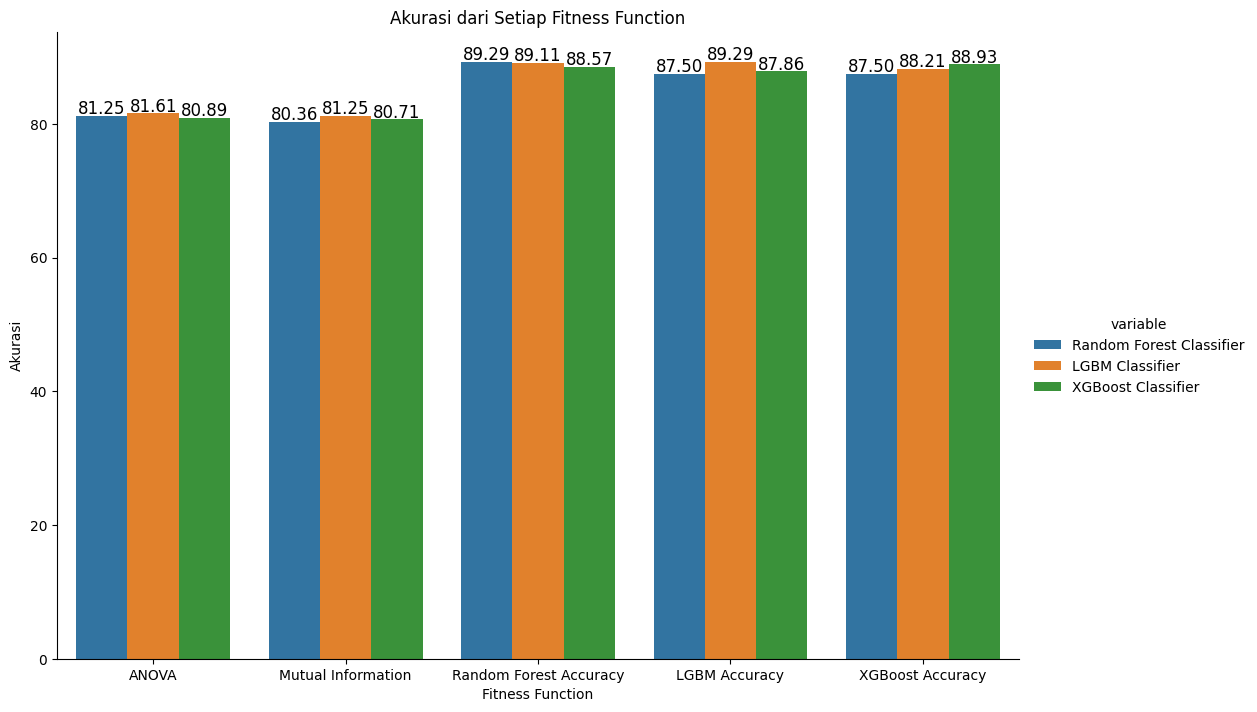

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 20))

# Create the bar plot
g = sns.catplot(
    data=datachart_melt, kind="bar",
    x="Fitness Function", y="value", hue="variable",
    height=7, aspect=1.5
)

g.set(ylabel='Akurasi', title="Akurasi dari Setiap Fitness Function")

# Add accuracy scores on top of each bar
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.show()


# Komparasi Waktu

Berikut kode program untuk tabel komparasi waktu.

In [28]:
waktu = pd.DataFrame()
waktu['Fitness Function'] = ['ANOVA', 'Mutual Information', 'Random Forest Accuracy', 'LGBM Accuracy', 'XGBoost Accuracy']
waktu['waktu_komputasi'] = [323, 19210, 52319, 60724, 72535]

In [29]:
waktu['waktu_komputasi_log'] = waktu['waktu_komputasi'].apply(lambda x: np.log(x))

In [30]:
waktu

,Fitness Function,waktu_komputasi,waktu_komputasi_log
0,ANOVA,323,5.777652
1,Mutual Information,19210,9.863186
2,Random Forest Accuracy,52319,10.865115
3,LGBM Accuracy,60724,11.014094
4,XGBoost Accuracy,72535,11.191824


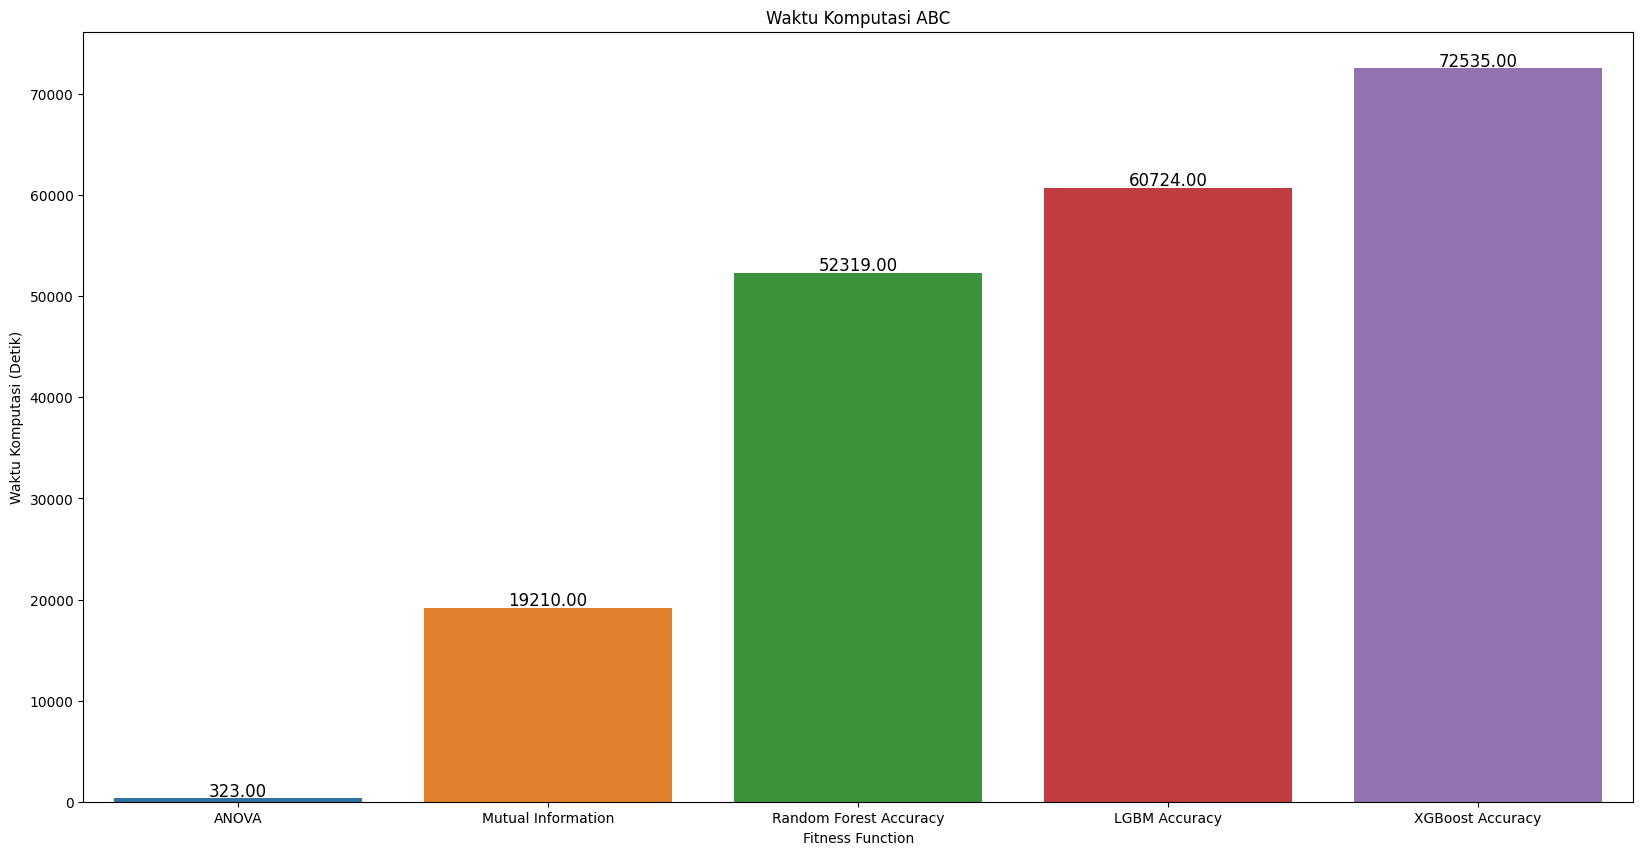

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 10))

# Create the bar plot
ax = sns.barplot(data=waktu, x="Fitness Function", y="waktu_komputasi")

ax.set(ylabel="Waktu Komputasi (Detik)", title="Waktu Komputasi ABC")

# Add time values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

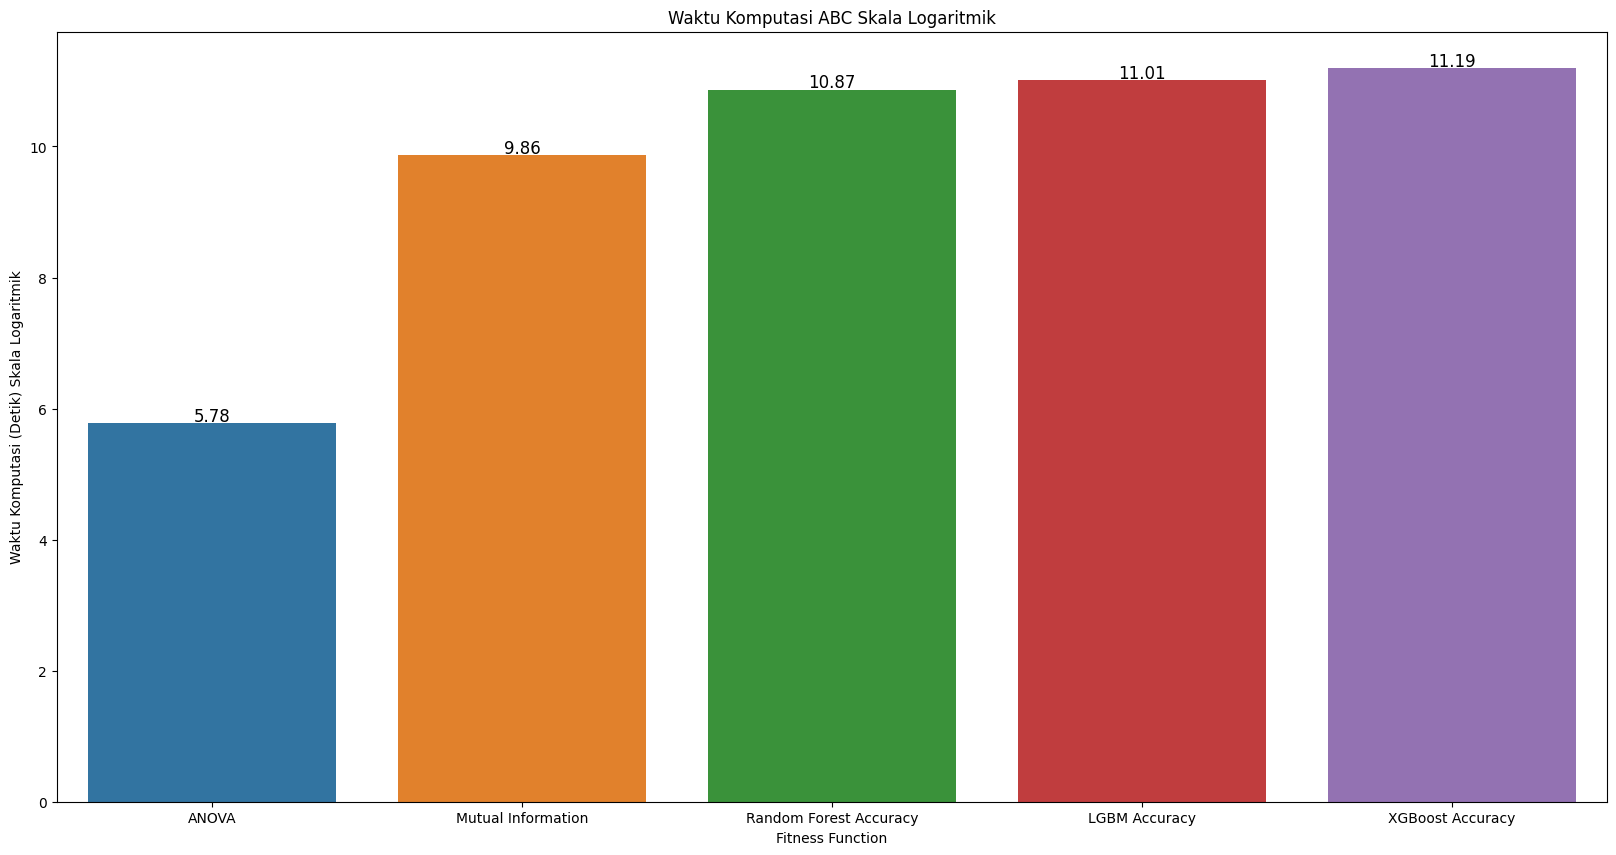

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 10))

# Create the bar plot
ax = sns.barplot(data=waktu, x="Fitness Function", y="waktu_komputasi_log")

ax.set(ylabel="Waktu Komputasi (Detik) Skala Logaritmik", title="Waktu Komputasi ABC Skala Logaritmik")

# Add time values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

# Penggunaan CPU

In [74]:
datachart = pd.DataFrame()

In [75]:
datachart['Fitness Function'] = ['Tanpa ABC', 'ANOVA', 'Mutual Information', 'Random Forest Accuracy', 'LGBM Accuracy', 'XGBoost Accuracy']

In [76]:
datachart['Random Forest Classifier'] = [18.9, 2.7, 3.3, 9.3, 5.6, 6.0]

In [77]:
datachart['LGBM Classifier'] = [26.2, 15.7, 18.8, 20.1, 14.4, 15.4]

In [78]:
datachart['XGBoost Classifier'] = [24.1, 13.3, 11.9, 12.3, 14.6, 14.7]

In [79]:
datachart

,Fitness Function,Random Forest Classifier,LGBM Classifier,XGBoost Classifier
0,Tanpa ABC,18.9,26.2,24.1
1,ANOVA,2.7,15.7,13.3
2,Mutual Information,3.3,18.8,11.9
3,Random Forest Accuracy,9.3,20.1,12.3
4,LGBM Accuracy,5.6,14.4,14.6
5,XGBoost Accuracy,6.0,15.4,14.7


In [80]:
datachart_melt = pd.melt(datachart, id_vars = ['Fitness Function'], var_name = "Model")

In [81]:
datachart_melt

,Fitness Function,Model,value
0,Tanpa ABC,Random Forest Classifier,18.9
1,ANOVA,Random Forest Classifier,2.7
2,Mutual Information,Random Forest Classifier,3.3
3,Random Forest Accuracy,Random Forest Classifier,9.3
4,LGBM Accuracy,Random Forest Classifier,5.6
5,XGBoost Accuracy,Random Forest Classifier,6.0
6,Tanpa ABC,LGBM Classifier,26.2
7,ANOVA,LGBM Classifier,15.7
8,Mutual Information,LGBM Classifier,18.8
9,Random Forest Accuracy,LGBM Classifier,20.1


<Figure size 1000x2000 with 0 Axes>

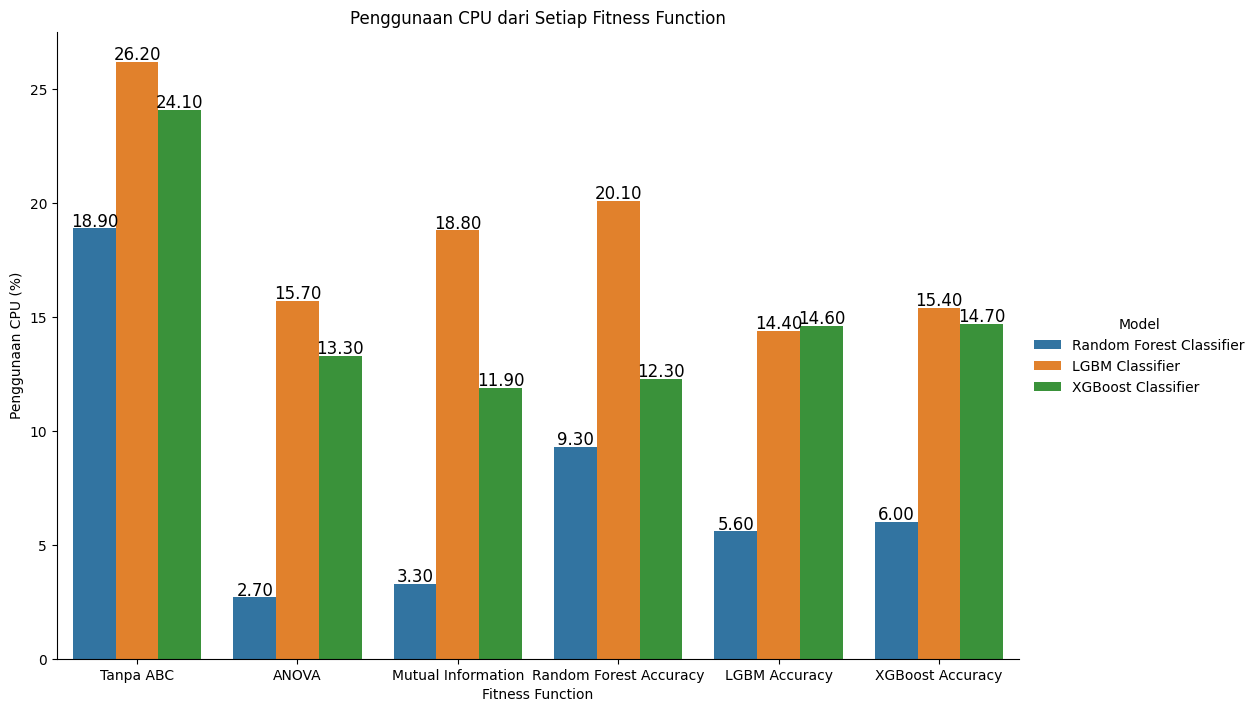

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 20))

# Create the bar plot
g = sns.catplot(
    data=datachart_melt, kind="bar",
    x="Fitness Function", y="value", hue="Model",
    height=7, aspect=1.5
)

g.set(ylabel='Penggunaan CPU (%)', title="Penggunaan CPU dari Setiap Fitness Function")

# Add accuracy scores on top of each bar
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.show()

# Penggunaan Memori 

In [87]:
datachart = pd.DataFrame()

In [88]:
datachart['Fitness Function'] = ['Tanpa ABC', 'ANOVA', 'Mutual Information', 'Random Forest Accuracy', 'LGBM Accuracy', 'XGBoost Accuracy']

In [89]:
datachart['Random Forest Classifier'] = [7.28, 7.39, 7.43, 7.25, 7.56, 7.40]

In [90]:
datachart['LGBM Classifier'] = [7.27, 7.38, 7.78, 7.68, 7.58, 7.35]

In [91]:
datachart['XGBoost Classifier'] = [7.27, 7.38, 7.79, 7.61, 7.56, 7.39]

In [92]:
datachart_melt = pd.melt(datachart, id_vars = ['Fitness Function'], var_name = "Model")

In [93]:
datachart_melt

,Fitness Function,Model,value
0,Tanpa ABC,Random Forest Classifier,7.28
1,ANOVA,Random Forest Classifier,7.39
2,Mutual Information,Random Forest Classifier,7.43
3,Random Forest Accuracy,Random Forest Classifier,7.25
4,LGBM Accuracy,Random Forest Classifier,7.56
5,XGBoost Accuracy,Random Forest Classifier,7.40
6,Tanpa ABC,LGBM Classifier,7.27
7,ANOVA,LGBM Classifier,7.38
8,Mutual Information,LGBM Classifier,7.78
9,Random Forest Accuracy,LGBM Classifier,7.68


<Figure size 1000x2000 with 0 Axes>

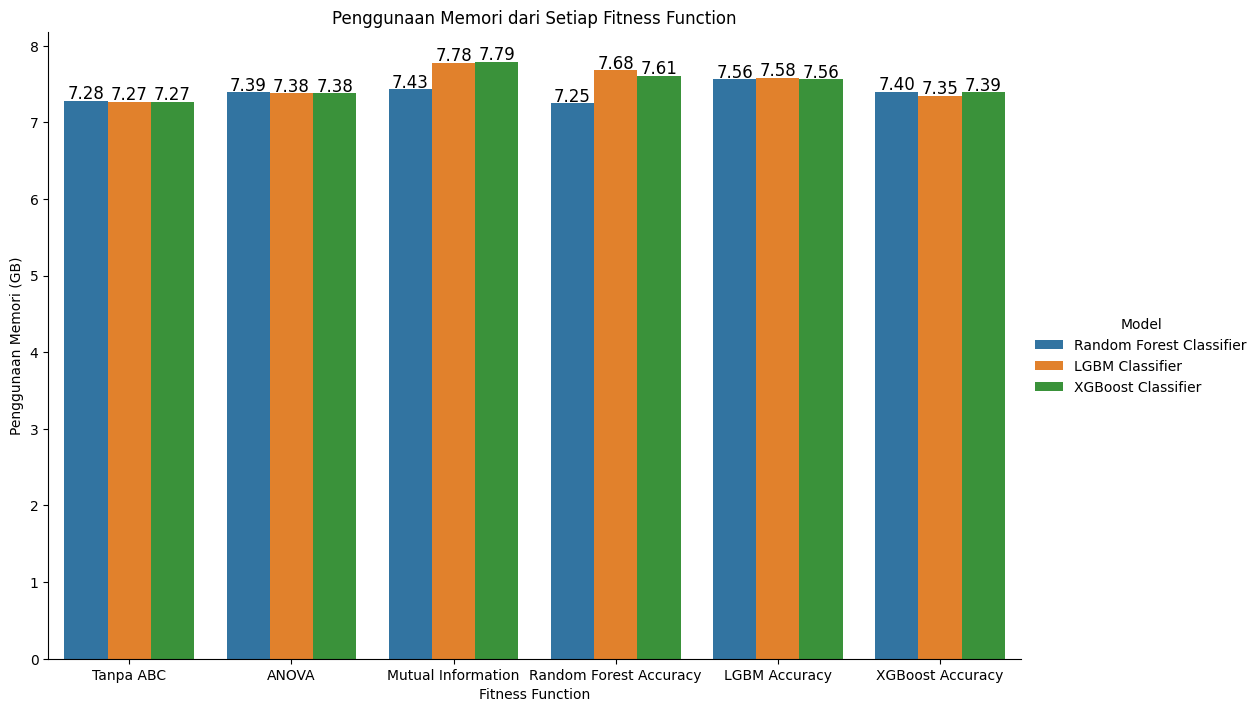

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 20))

# Create the bar plot
g = sns.catplot(
    data=datachart_melt, kind="bar",
    x="Fitness Function", y="value", hue="Model",
    height=7, aspect=1.5
)

g.set(ylabel='Penggunaan Memori (GB)', title="Penggunaan Memori dari Setiap Fitness Function")

# Add accuracy scores on top of each bar
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.show()

# Waktu Komputasi

In [96]:
datachart = pd.DataFrame()

In [97]:
datachart['Fitness Function'] = ['Tanpa ABC', 'ANOVA', 'Mutual Information', 'Random Forest Accuracy', 'LGBM Accuracy', 'XGBoost Accuracy']

In [106]:
datachart['Random Forest Classifier'] = [1.313, 0.156, 0.203, 0.031, 0.016, 0.015]

In [107]:
datachart['LGBM Classifier'] = [0.438, 0.141, 0.156, 0.015, 0.0, 0.016]

In [108]:
datachart['XGBoost Classifier'] = [1.625, 0.141, 0.266, 0.0, 0.0, 0.0]

In [109]:
datachart_melt = pd.melt(datachart, id_vars = ['Fitness Function'], var_name = "Model")

<Figure size 1000x2000 with 0 Axes>

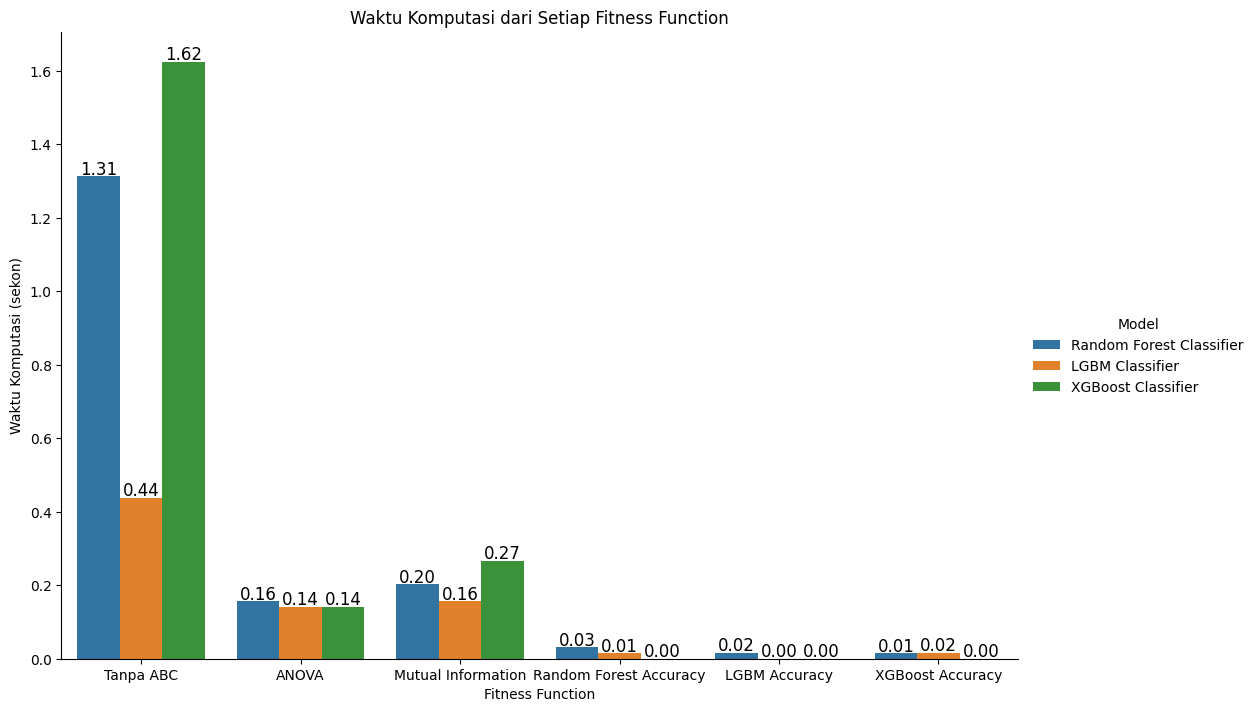

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 20))

# Create the bar plot
g = sns.catplot(
    data=datachart_melt, kind="bar",
    x="Fitness Function", y="value", hue="Model",
    height=7, aspect=1.5
)

g.set(ylabel='Waktu Komputasi (sekon)', title="Waktu Komputasi dari Setiap Fitness Function")

# Add accuracy scores on top of each bar
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.show()

In [ ]:
[['Diss_sim_d5_a0', 'Homogen_d5_a2.356194490192345', 'Energy_d3_a0', 'Color_438', 'skewnessG', 'Contrast_d1_a0', 'varianceR', 'Diss_sim_d1_a0']]

In [12]:
pip install lightgbm

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
    --------------------------------------- 0.0/1.3 MB 131.3 kB/s eta 0:00:11
    --------------------------------------- 0.0/1.3 MB 163.8 kB/s eta 0:00:08
   - -------------------------------------- 0.1/1.3 MB 217.9 kB/s eta 0:00:06
   --- ------------------------------------ 0.1/1.3 MB 393.8 kB/s eta 0:00:04
   ----- ---------------------------------- 0.2/1.3 MB 586.1 kB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.3 MB 744.2 kB/s eta 0:00:02
   -------- ------------------------------- 0.3/1.3 MB 764.6 kB/s eta 0:00:02
   ----------- ---------------------------- 0.4/1.3 MB 888.4 kB/s eta 0:00:02
   --------------- ------------------------ 0.5/1.3 MB 1.0 MB/s eta 0:00:01
   ----------------- ---

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

lgbm = RandomForestClassifier()
lgbm.fit(train[['skewnessR', 'skewnessB', 'meanR', 'meanG', 'meanB', 'varianceG', 'skewnessG', 'varianceR']], y_train)
filename = 'random_forest_model.sav'
pickle.dump(lgbm, open(filename, 'wb'))

In [14]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score

lgbm = LGBMClassifier()
lgbm.fit(train[['Homogen_d1_a0', 'Color_511', 'skewnessG', 'Color_438', 'varianceR', 'varianceG', 'Corr_d1_a0.7853981633974483', 'Color_292']], y_train)
filename = 'lgbm_model_xgb.sav'
pickle.dump(lgbm, open(filename, 'wb'))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1301, number of used features: 8
[LightGBM] [Info] Start training from score -1.421495
[LightGBM] [Info] Start training from score -1.994739
[LightGBM] [Info] Start training from score -1.327344
[LightGBM] [Info] Start training from score -1.028851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

xgboost = XGBClassifier()
xgboost.fit(train[['Homogen_d1_a0', 'Color_511', 'skewnessG', 'Color_438', 'varianceR', 'varianceG', 'Corr_d1_a0.7853981633974483', 'Color_292']], y_train)
filename = 'xgboost_model_xgb.sav'
pickle.dump(xgboost, open(filename, 'wb'))

In [8]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score

lgbm = LGBMClassifier()
lgbm.fit(train[['skewnessR', 'skewnessB', 'meanR', 'meanG', 'meanB', 'varianceG', 'skewnessG', 'varianceR']], y_train)
filename = 'lgbm_model.sav'
pickle.dump(lgbm, open(filename, 'wb'))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1301, number of used features: 8
[LightGBM] [Info] Start training from score -1.421495
[LightGBM] [Info] Start training from score -1.994739
[LightGBM] [Info] Start training from score -1.327344
[LightGBM] [Info] Start training from score -1.028851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [11]:
pip install xgboost

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 640.0 kB/s eta 0:02:36
   ---------------------------------------- 0.1/99.8 MB 812.7 kB/s eta 0:02:03
   ---------------------------------------- 0.2/99.8 MB 1.5 MB/s eta 0:01:08
   ---------------------------------------- 0.3/99.8 MB 1.8 MB/s eta 0:00:57
   ---------------------------------------- 0.4/99.8 MB 2.0 MB/s eta 0:00:51
   ---------------------------------------- 0.5/99.8 MB 1.7 MB/s eta 0:01:00
   ---------------------------------------- 0.5/99.8 MB 1.7 MB/s eta 0:01:00
   ---------------------------------------- 0.6/99.8 MB 1.6 MB/s eta 0:01:03
   ---------------------------------------- 0.6/99.8 MB 1.4 MB/s eta 0:01:11
   ---------------------------------------- 0.6/99.8 MB 1.3 MB/s eta 0:01:15
   ---------------------------------------- 0.7/99.8 MB 1.3 MB/s eta 0:01:17
   ---------------------------------------- 0.7/99.8 MB 1.2 MB/s eta 0:01:21
  

In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

xgboost = XGBClassifier()
xgboost.fit(train[['skewnessR', 'skewnessB', 'meanR', 'meanG', 'meanB', 'varianceG', 'skewnessG', 'varianceR']], y_train)
filename = 'xgboost_model.sav'
pickle.dump(xgboost, open(filename, 'wb'))